# 5c. Gene Expression MDE Scatter (Feature) Plots

Per-sample MDE scatter plots colored by gene expression,
with concave hull background contours.
Generates NANOG and SOX21 feature maps for Fig 1 (H1) and Fig 2 (Ctrl vs JARID2).

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.spatial import Delaunay
from scipy.ndimage import gaussian_filter1d
from shapely.geometry import MultiLineString
from shapely.ops import unary_union, polygonize

/scratch/users/chensj16/venvs/dl2025/.venv/lib/python3.12/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


## Load data

In [2]:
adata_merged = sc.read_h5ad('adata_merged.250505-canonical.h5ad')

In [3]:
# Figure 1 samples (H1 differentiation series)
sample_sel1 = adata_merged.obs['sample'].isin(
    ['H1-hPSC.p6', 'H1-0.5E', 'H1-0.5ET', 'H1-0.5E4T', 'H1-E', 'H1-ET', 'H1-E4T.1']
)
adata1 = adata_merged[sample_sel1].copy()

# Figure 2 samples (Ctrl vs JARID2)
sample_sel2 = adata_merged.obs['sample'].isin(
    ['Ctrl-hPSC.p1', 'Ctrl-E.p6', 'Ctrl-ET.p1', 'H1-E4T.3',
     'JARID2-hPSC', 'JARID2-E', 'JARID2-ET', 'JARID2-E4T']
)
adata2 = adata_merged[sample_sel2].copy()

## Concave hull helper functions

In [4]:
def concave_hull(points, alpha=2.0, buffer_dist=0.15, resolution=128):
    """Concave hull (alpha shape) with smooth buffered margin."""
    pts = np.array(points)
    tri = Delaunay(pts)
    edges = set()
    for simplex in tri.simplices:
        pa, pb, pc = pts[simplex]
        a = np.linalg.norm(pa - pb)
        b = np.linalg.norm(pb - pc)
        c = np.linalg.norm(pc - pa)
        s = (a + b + c) / 2.0
        area_sq = s * (s - a) * (s - b) * (s - c)
        if area_sq > 0:
            circum_r = (a * b * c) / (4.0 * np.sqrt(area_sq))
        else:
            continue
        if circum_r < 1.0 / alpha:
            for i, j in [(0, 1), (1, 2), (2, 0)]:
                edge = tuple(sorted([simplex[i], simplex[j]]))
                edges.add(edge)
    lines = [((pts[i][0], pts[i][1]), (pts[j][0], pts[j][1])) for i, j in edges]
    m = MultiLineString(lines)
    polys = list(polygonize(m))
    if not polys:
        return None
    return unary_union(polys).buffer(buffer_dist, resolution=resolution)


def smooth_hull_coords(hull, sigma=3):
    """Extract hull boundary coords and apply Gaussian smoothing."""
    if hull is None:
        return []
    polygons = [hull] if hull.geom_type == 'Polygon' else list(hull.geoms)
    result = []
    for poly in polygons:
        x, y = np.array(poly.exterior.coords.xy)
        x_smooth = gaussian_filter1d(x, sigma=sigma, mode='wrap')
        y_smooth = gaussian_filter1d(y, sigma=sigma, mode='wrap')
        result.append((x_smooth, y_smooth))
    return result


def plot_hull(ax, hull_coords_list, **kwargs):
    """Draw pre-smoothed hull boundaries on axes."""
    defaults = dict(linestyle='--', color='gray', linewidth=1, alpha=0.8)
    defaults.update(kwargs)
    for (x, y) in hull_coords_list:
        ax.plot(x, y, **defaults)


def hull_bounds(hull_coords_list, pad=0.05):
    """Get bounding box of hull coords with extra padding."""
    all_x = np.concatenate([x for x, y in hull_coords_list])
    all_y = np.concatenate([y for x, y in hull_coords_list])
    return (all_x.min() - pad, all_x.max() + pad,
            all_y.min() - pad, all_y.max() + pad)

## MDE feature plot function

In [17]:
# Hull / plot parameters
ALPHA = 2.0
BUFFER = 0.15
SMOOTH_RES = 128
GAUSS_SIGMA = 3
SUBSAMPLE = 5000
vmin, vmax = 0, 1.5

mycmap = mcolors.LinearSegmentedColormap.from_list(
    'custom_cmap', ['#d1cfd4', '#9577e5', '#1206f5'])


def compute_hull(adata):
    """Compute concave hull coords from adata MDE embedding."""
    all_pts = adata.obsm['X_mde']
    if len(all_pts) > SUBSAMPLE:
        idx = np.random.default_rng(42).choice(len(all_pts), SUBSAMPLE, replace=False)
        hull_pts = all_pts[idx]
    else:
        hull_pts = all_pts
    hull_raw = concave_hull(hull_pts, alpha=ALPHA, buffer_dist=BUFFER, resolution=SMOOTH_RES)
    return smooth_hull_coords(hull_raw, sigma=GAUSS_SIGMA)


def plot_gene_mde(gene, adata, sample_list, hull_coords, save_path, ncols=4):
    """Per-sample MDE feature plot with concave hull background."""
    nrows = (len(sample_list) + ncols - 1) // ncols
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    xlo, xhi, ylo, yhi = hull_bounds(hull_coords, pad=0.05)

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 5*nrows))
    axes = axes.flatten()
    sns.set_theme(style='white')

    for i, sample_name in enumerate(sample_list):
        adata_sub = adata[adata.obs['sample'] == sample_name].copy()
        data = pd.DataFrame(adata_sub.obsm['X_mde'], columns=['MDE_1', 'MDE_2'])
        data[gene] = adata_sub[:, gene].X.toarray().flatten()
        data = data.sort_values(gene).copy()

        ax = axes[i]
        for spine in ax.spines.values():
            spine.set_visible(False)

        plot_hull(ax, hull_coords)

        scatter = sns.scatterplot(
            data=data, x='MDE_1', y='MDE_2', hue=gene,
            palette=mycmap, s=2, alpha=1.00, edgecolor=None,
            hue_norm=(vmin, vmax), legend=False, ax=ax
        )
        mappable = scatter.collections[0]
        mappable.set_cmap(mycmap)
        mappable.set_norm(norm)

        ax.set_title(f'$\\it{{{gene}}}$ in {sample_name}')
        ax.set_xticks([]); ax.set_yticks([])
        ax.set_xlim(xlo, xhi); ax.set_ylim(ylo, yhi)

    fig.subplots_adjust(right=0.9)
    cbar_ax = fig.add_axes([0.92, 0.3, 0.015, 0.4])
    cbar = fig.colorbar(mappable, cax=cbar_ax)
    cbar.outline.set_visible(False)
    cbar.set_label(f'$\\it{{{gene}}}$ expression')

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.subplots_adjust(wspace=0.3, hspace=0.4)
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f'Saved: {save_path}')
    plt.show()

## Precompute hulls

In [18]:
hull_coords = compute_hull(adata_merged)

In [7]:
fig1_samples = ['H1-hPSC.p6', 'H1-0.5E', 'H1-0.5ET', 'H1-0.5E4T',
                'H1-E', 'H1-ET', 'H1-E4T.1']
fig2_samples = ['Ctrl-hPSC.p1', 'JARID2-hPSC', 'Ctrl-E.p6', 'JARID2-E',
                'Ctrl-ET.p1', 'JARID2-ET', 'H1-E4T.3', 'JARID2-E4T']

## Figure 1 — MDE feature plot

Saved: figures/Figure1.NANOG.MDEmap.pdf


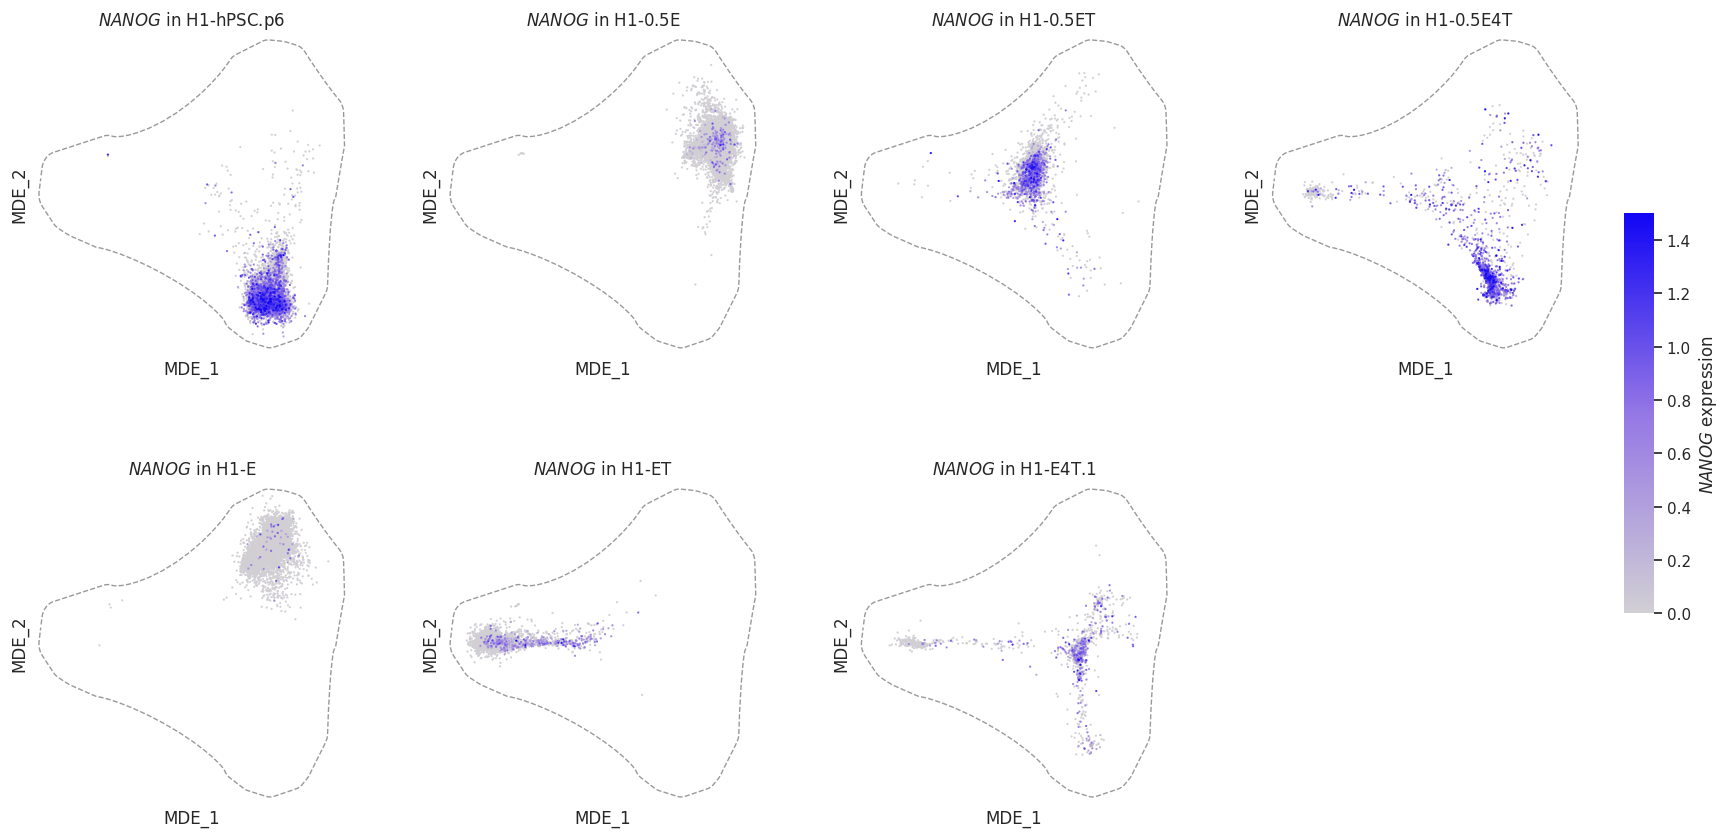

Saved: figures/Figure1.SOX21.MDEmap.pdf


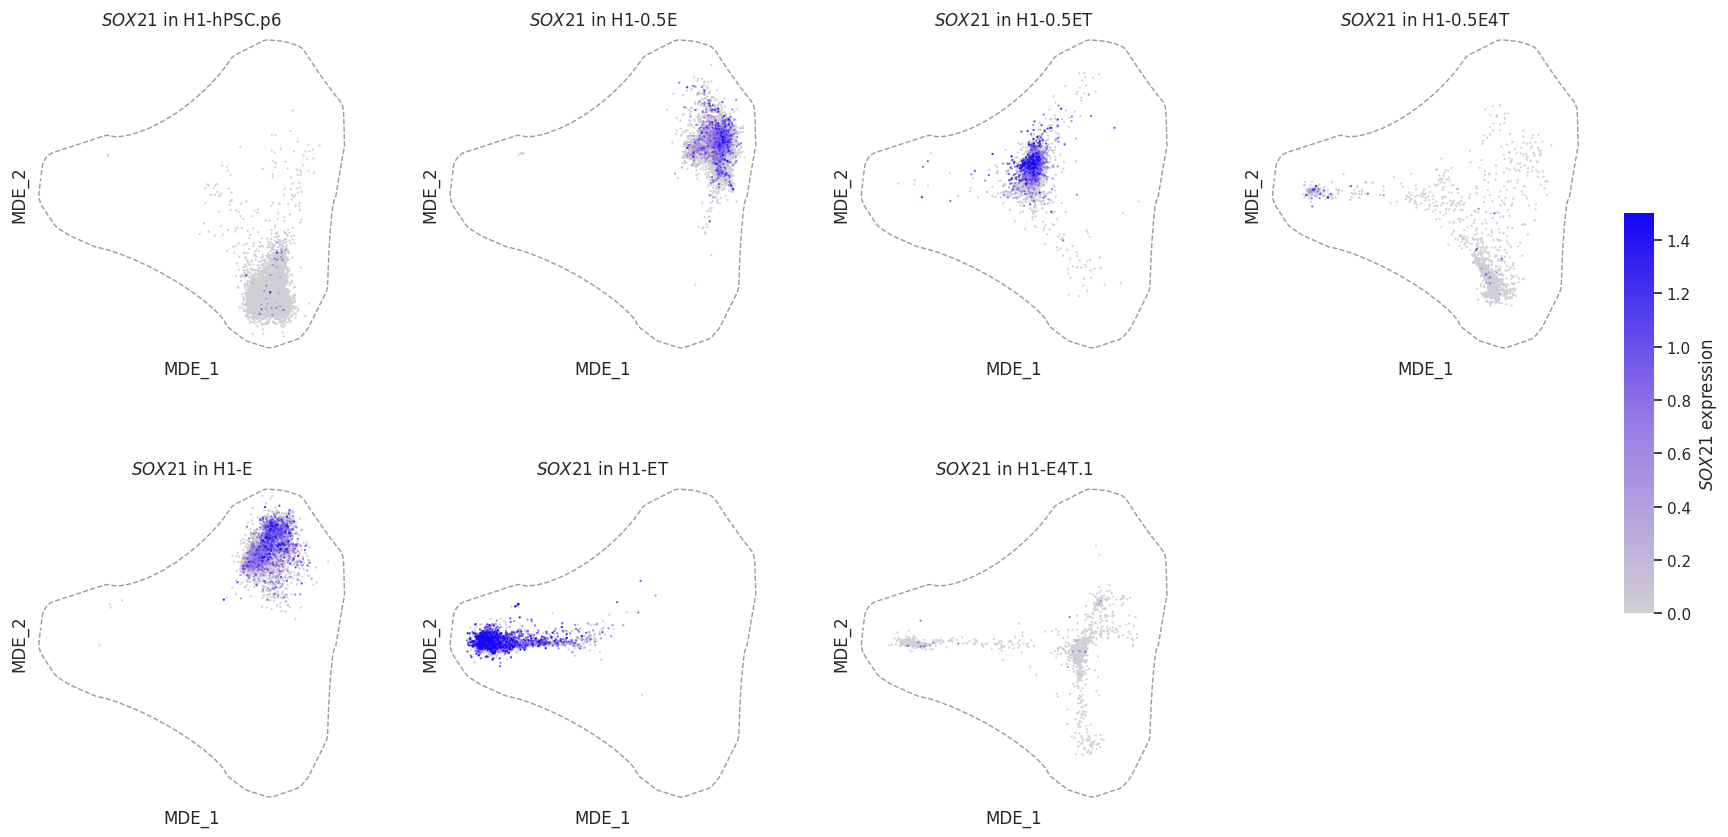

Saved: figures/Figure1.OTX2.MDEmap.pdf


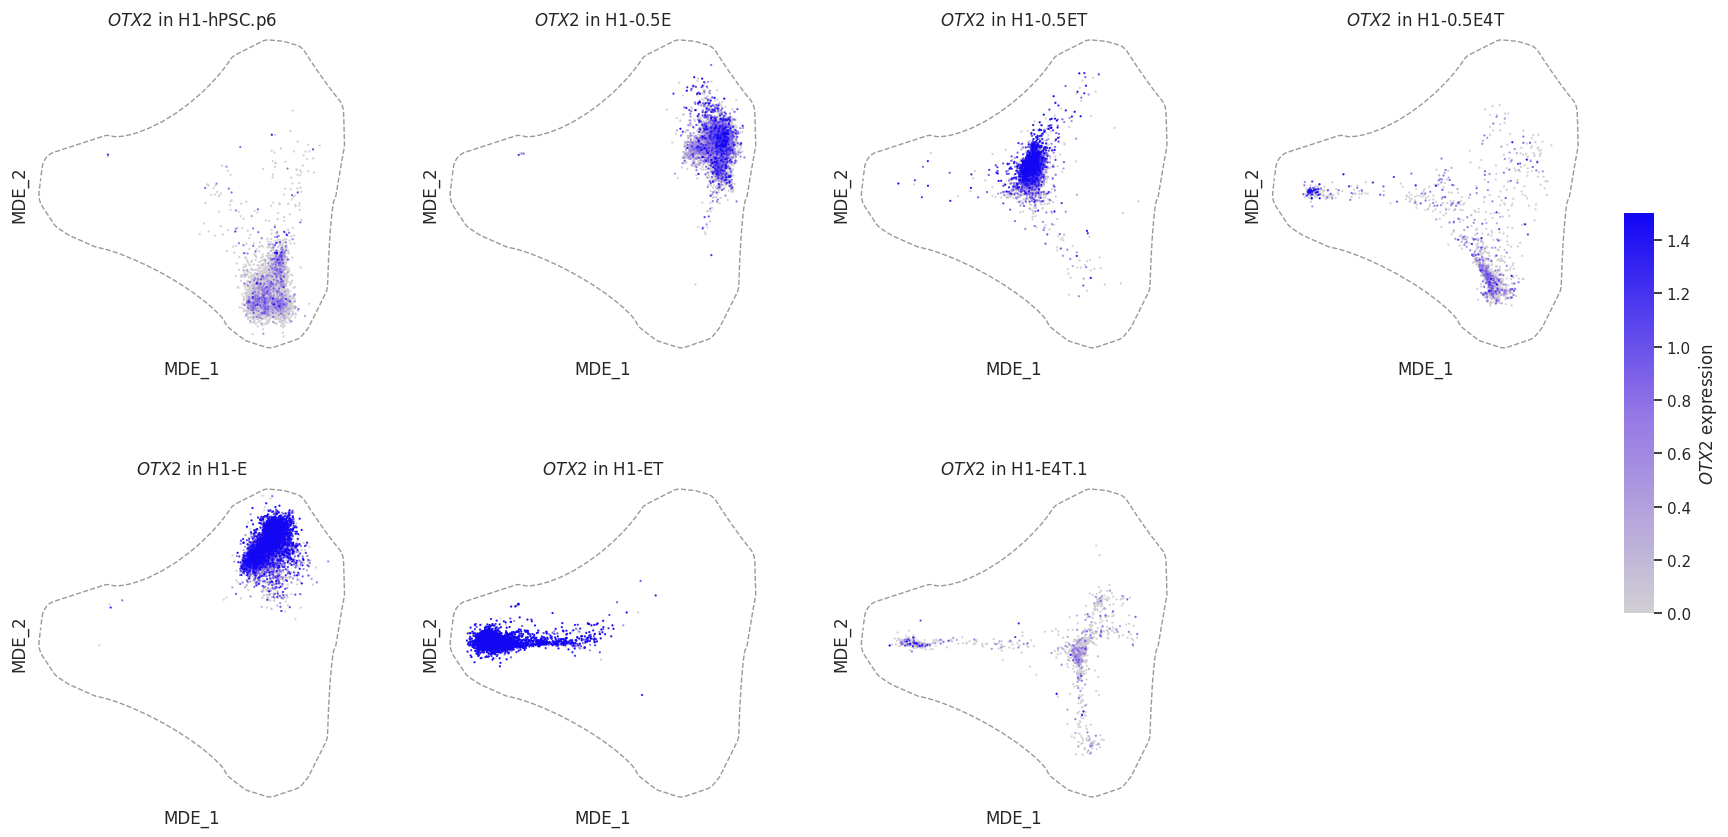

Saved: figures/Figure1.ZIC1.MDEmap.pdf


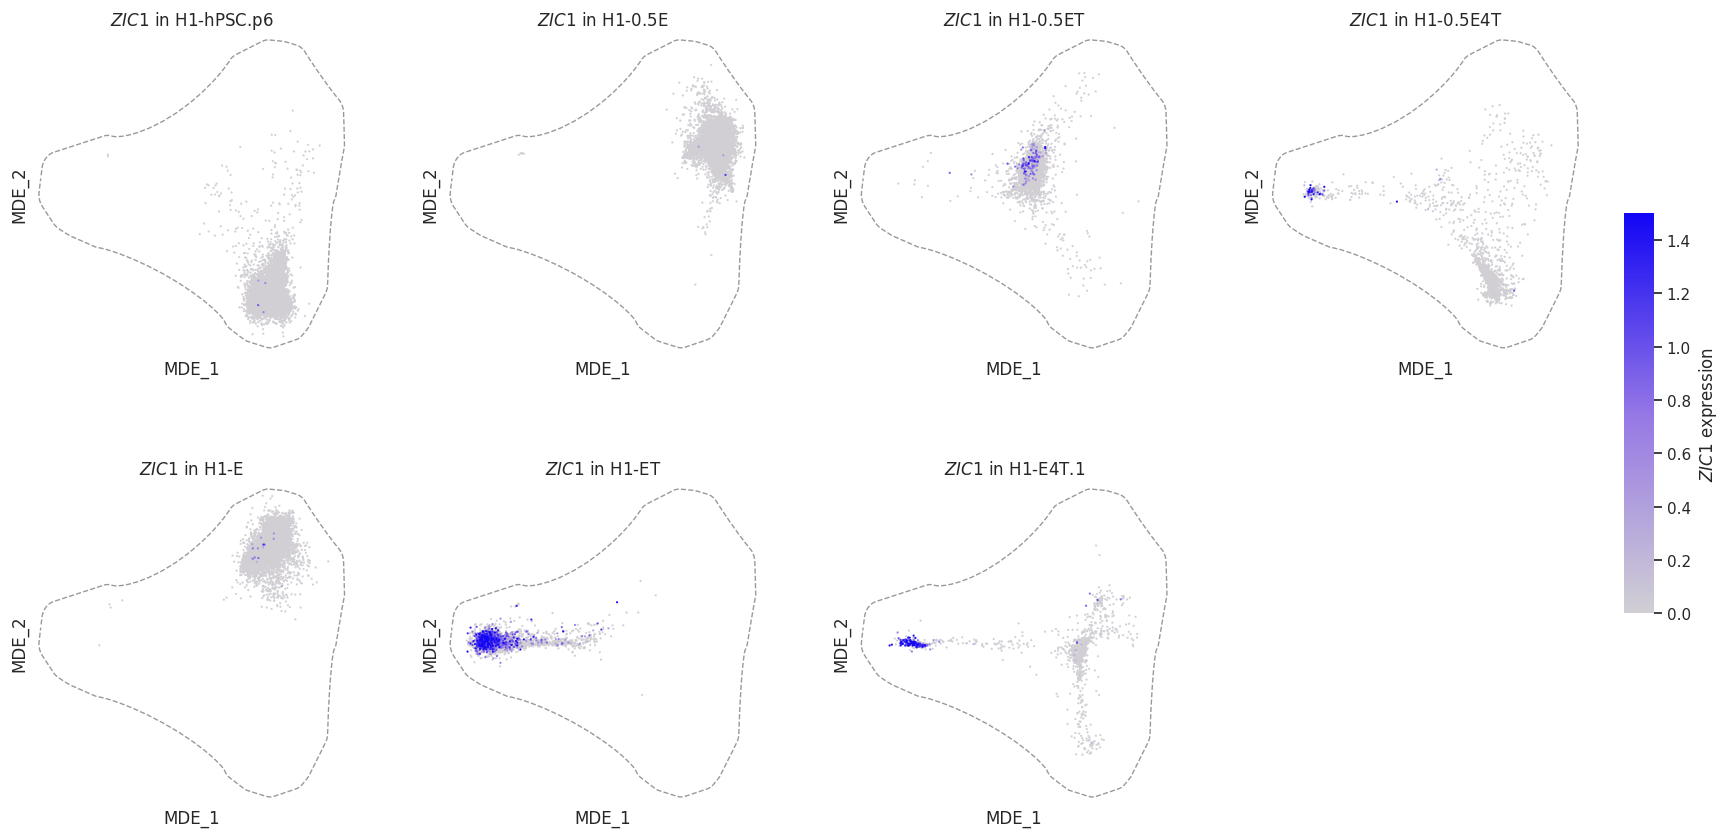

Saved: figures/Figure1.NES.MDEmap.pdf


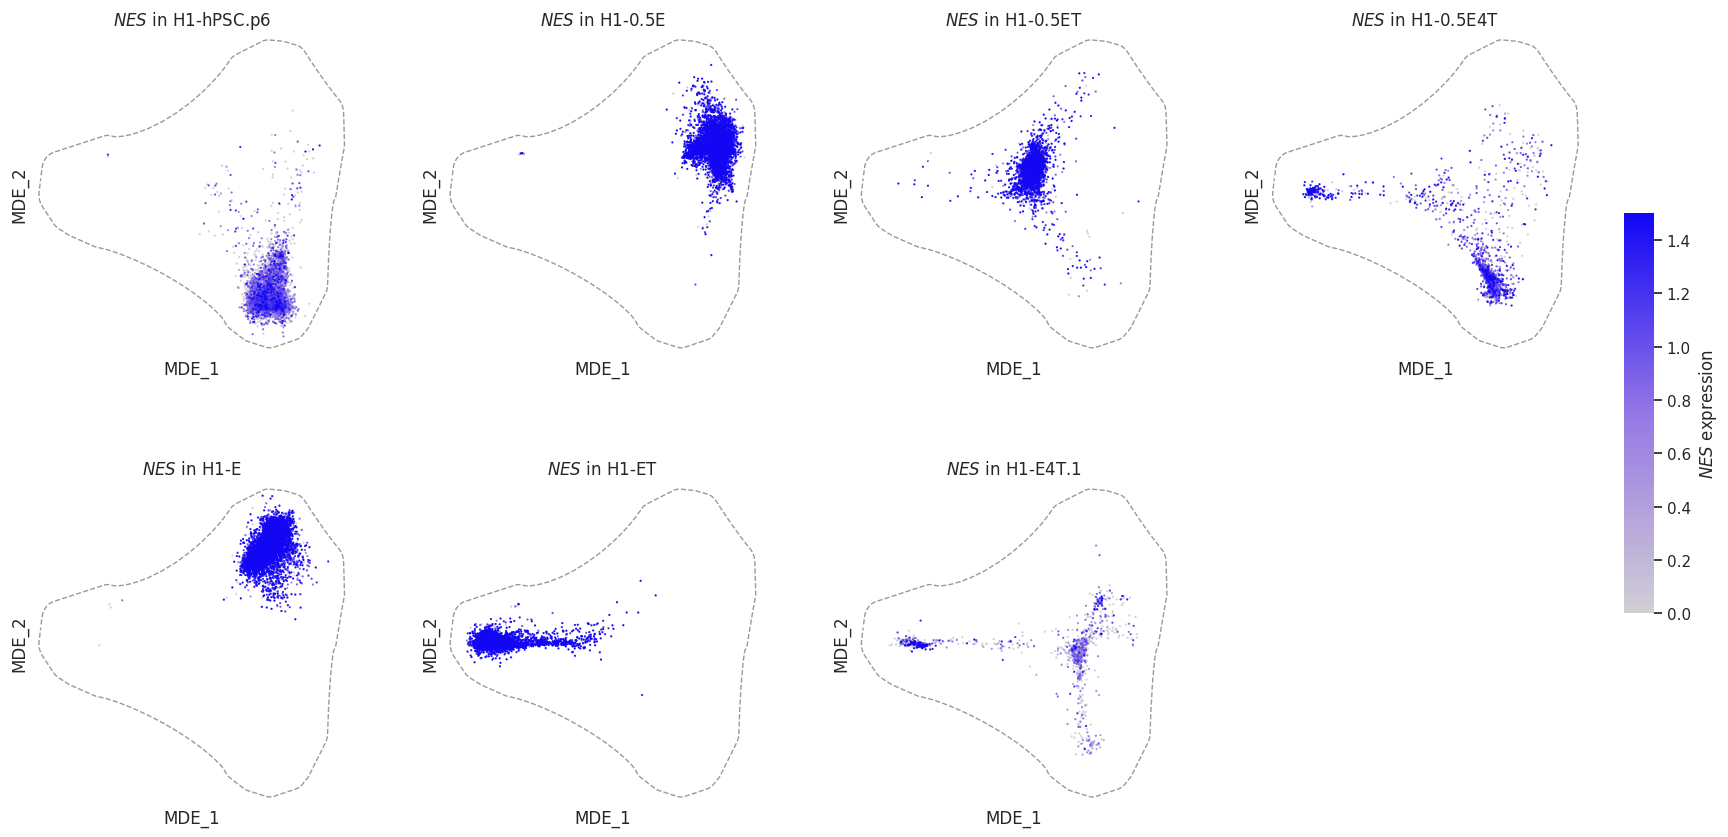

Saved: figures/Figure1.SOX1.MDEmap.pdf


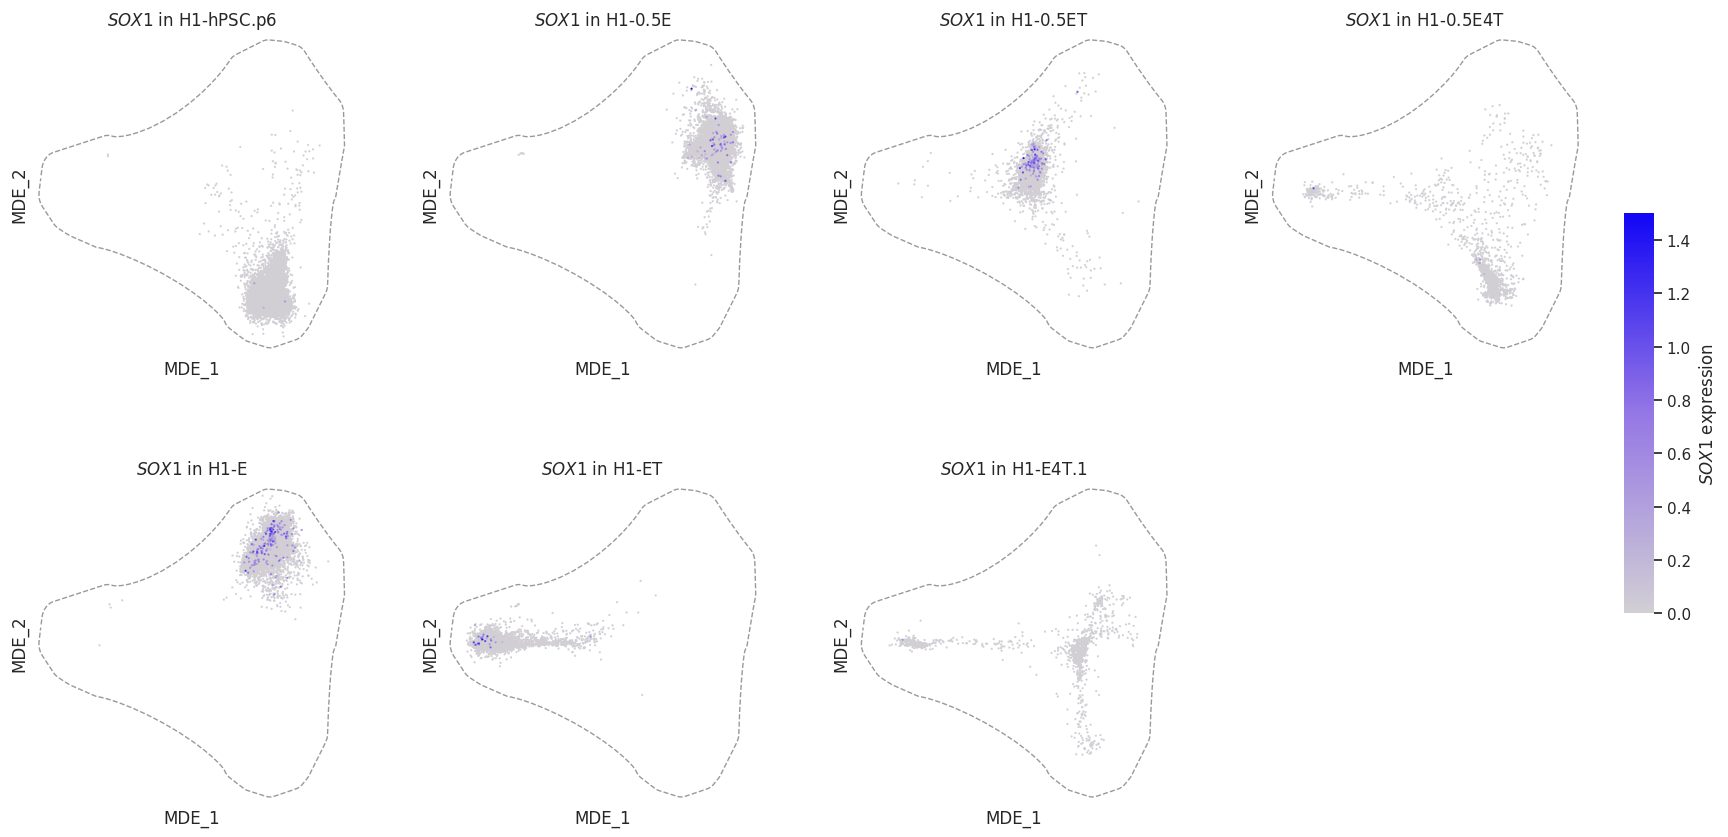

Saved: figures/Figure1.MAP2.MDEmap.pdf


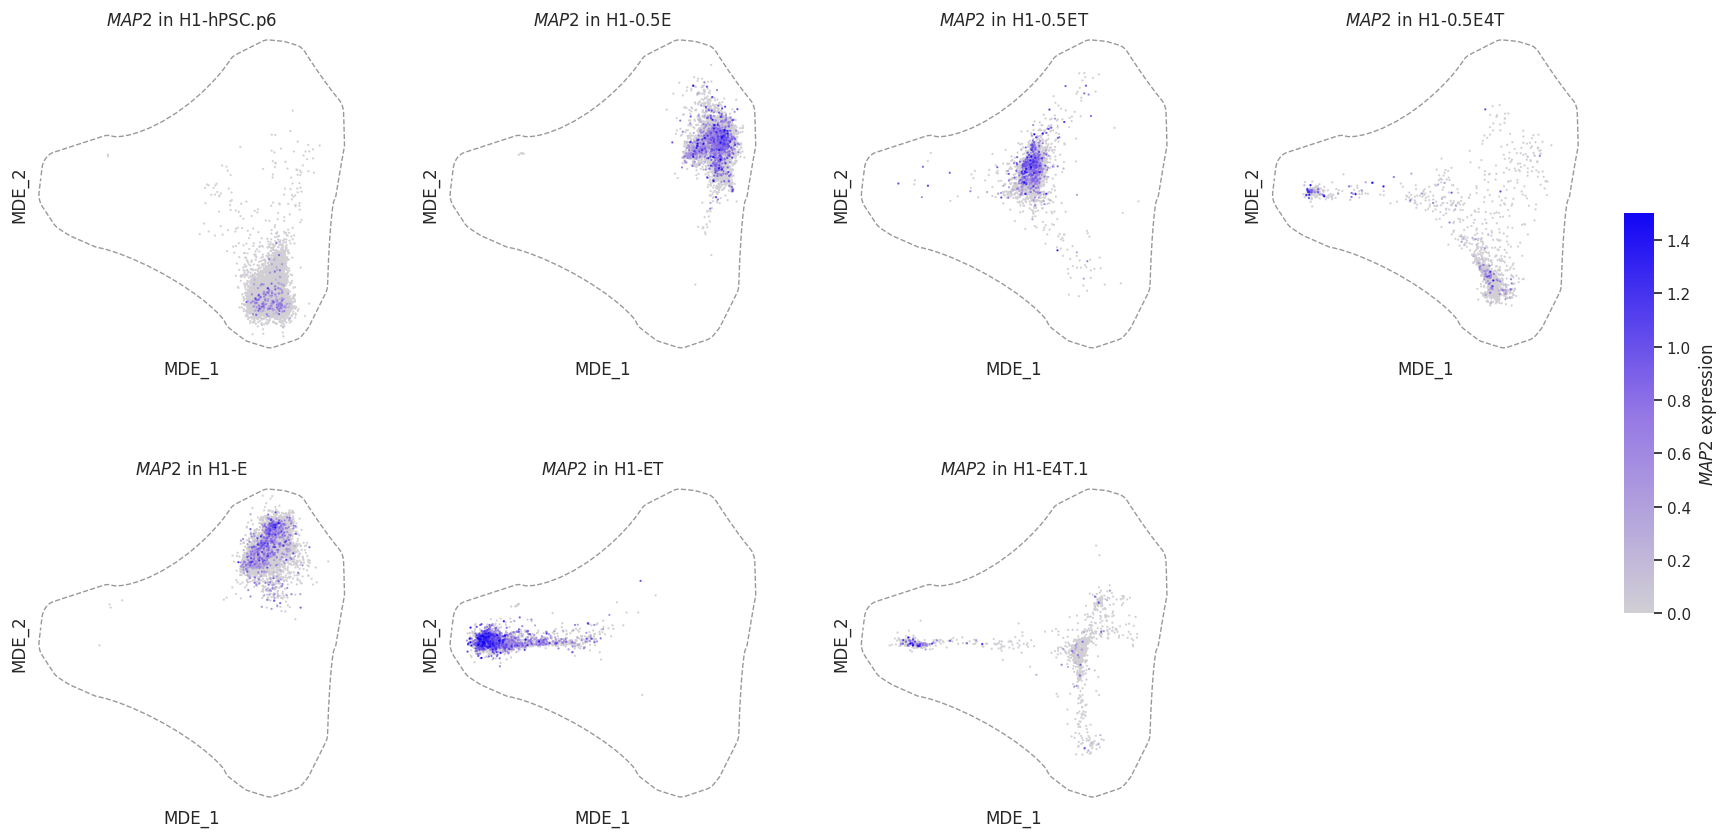

Saved: figures/Figure1.COL2A1.MDEmap.pdf


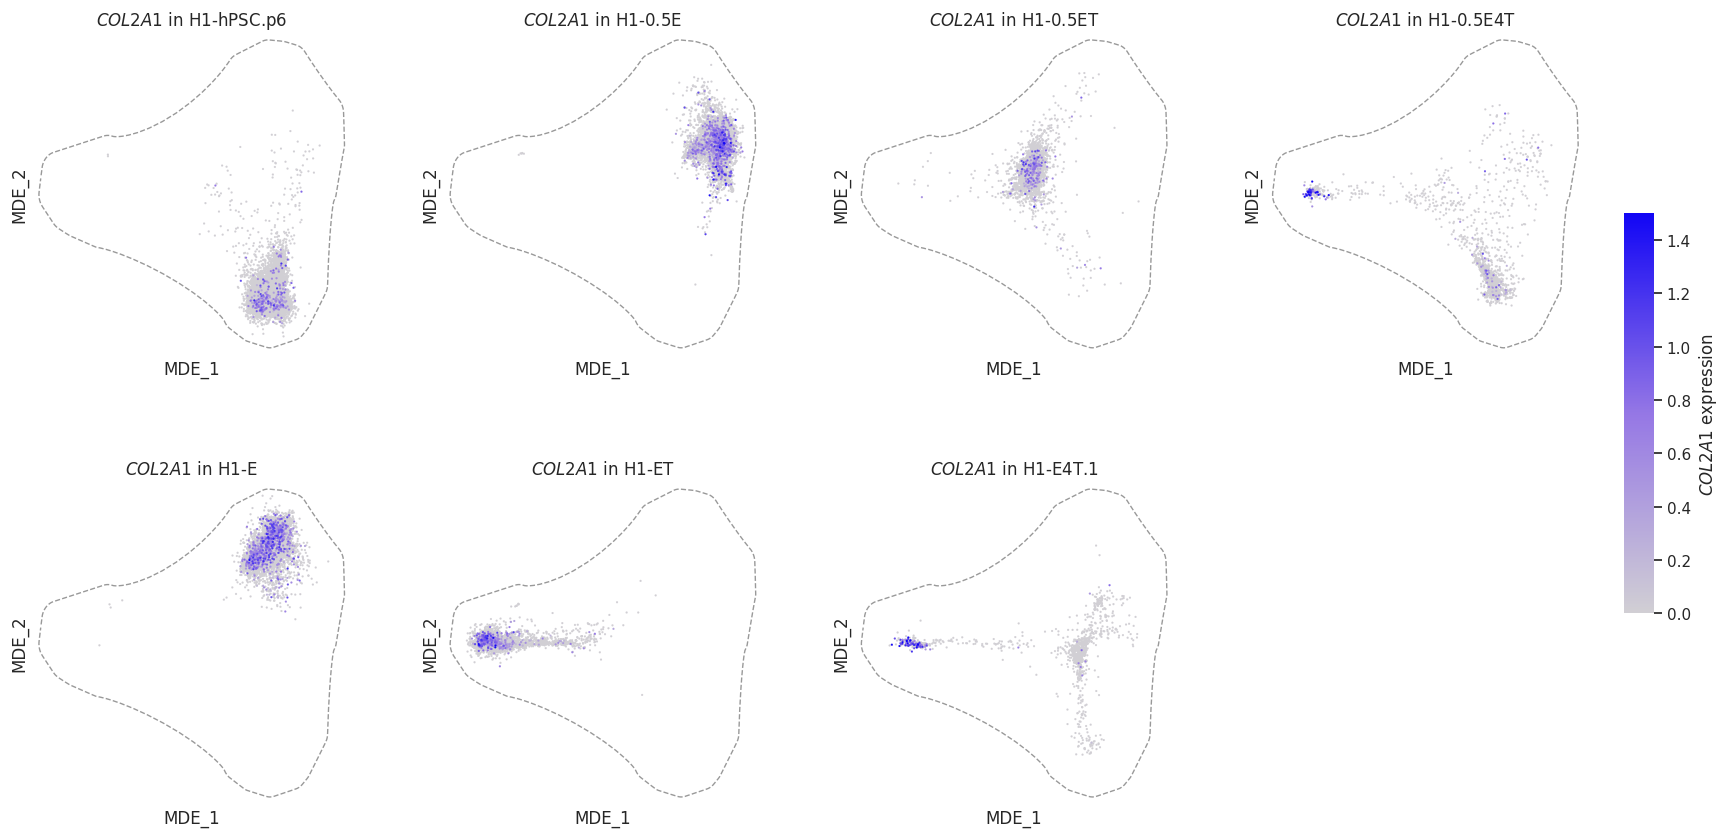

Saved: figures/Figure1.TFAP2C.MDEmap.pdf


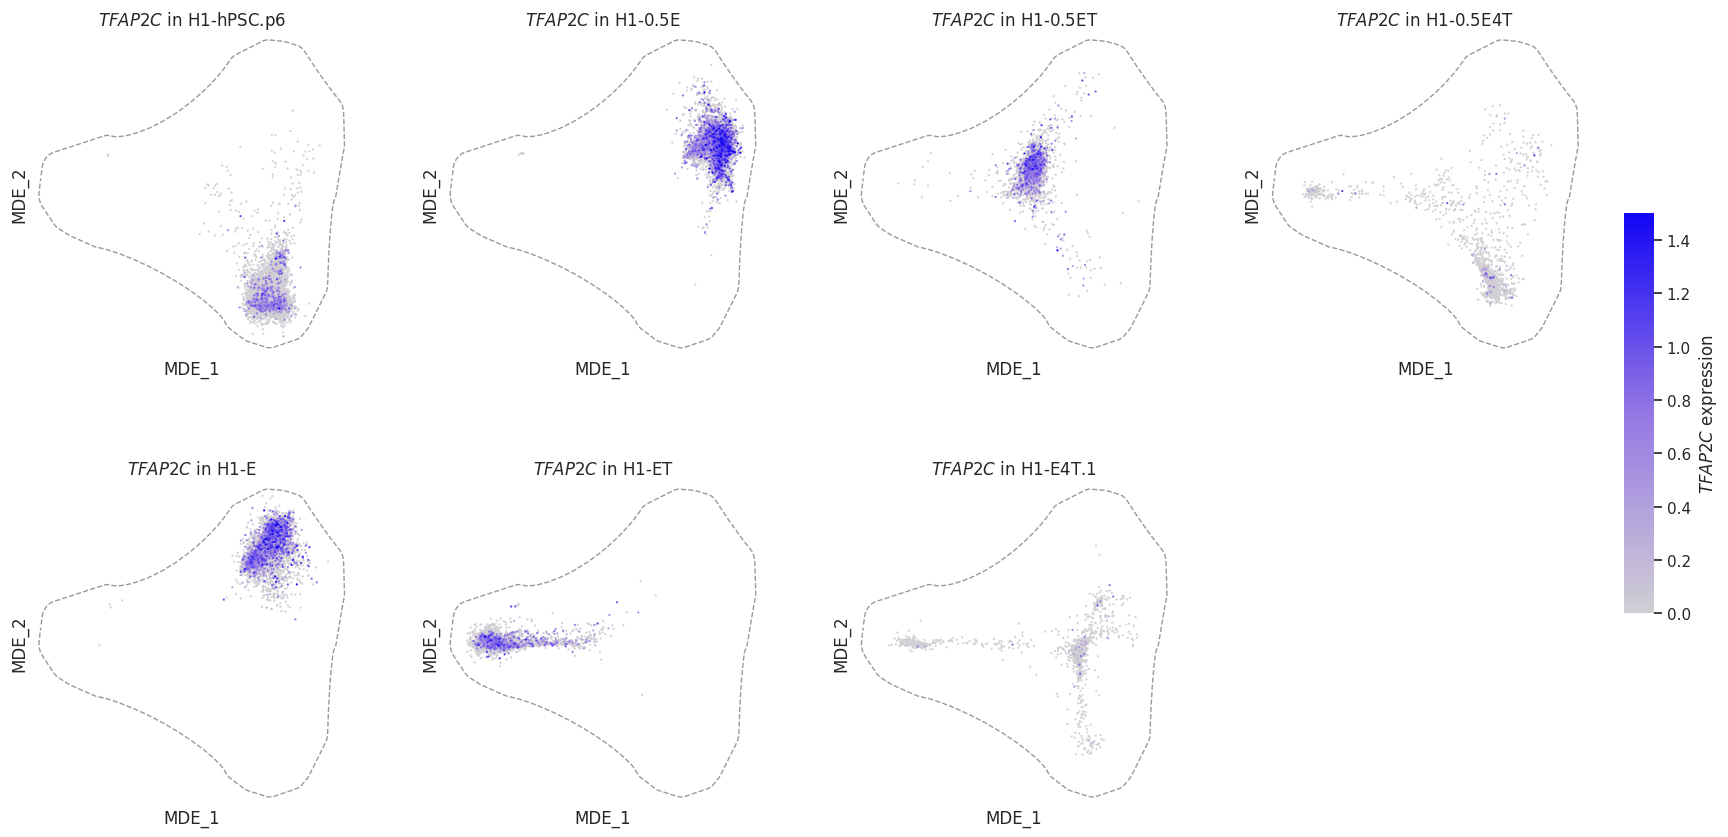

Saved: figures/Figure1.CDH11.MDEmap.pdf


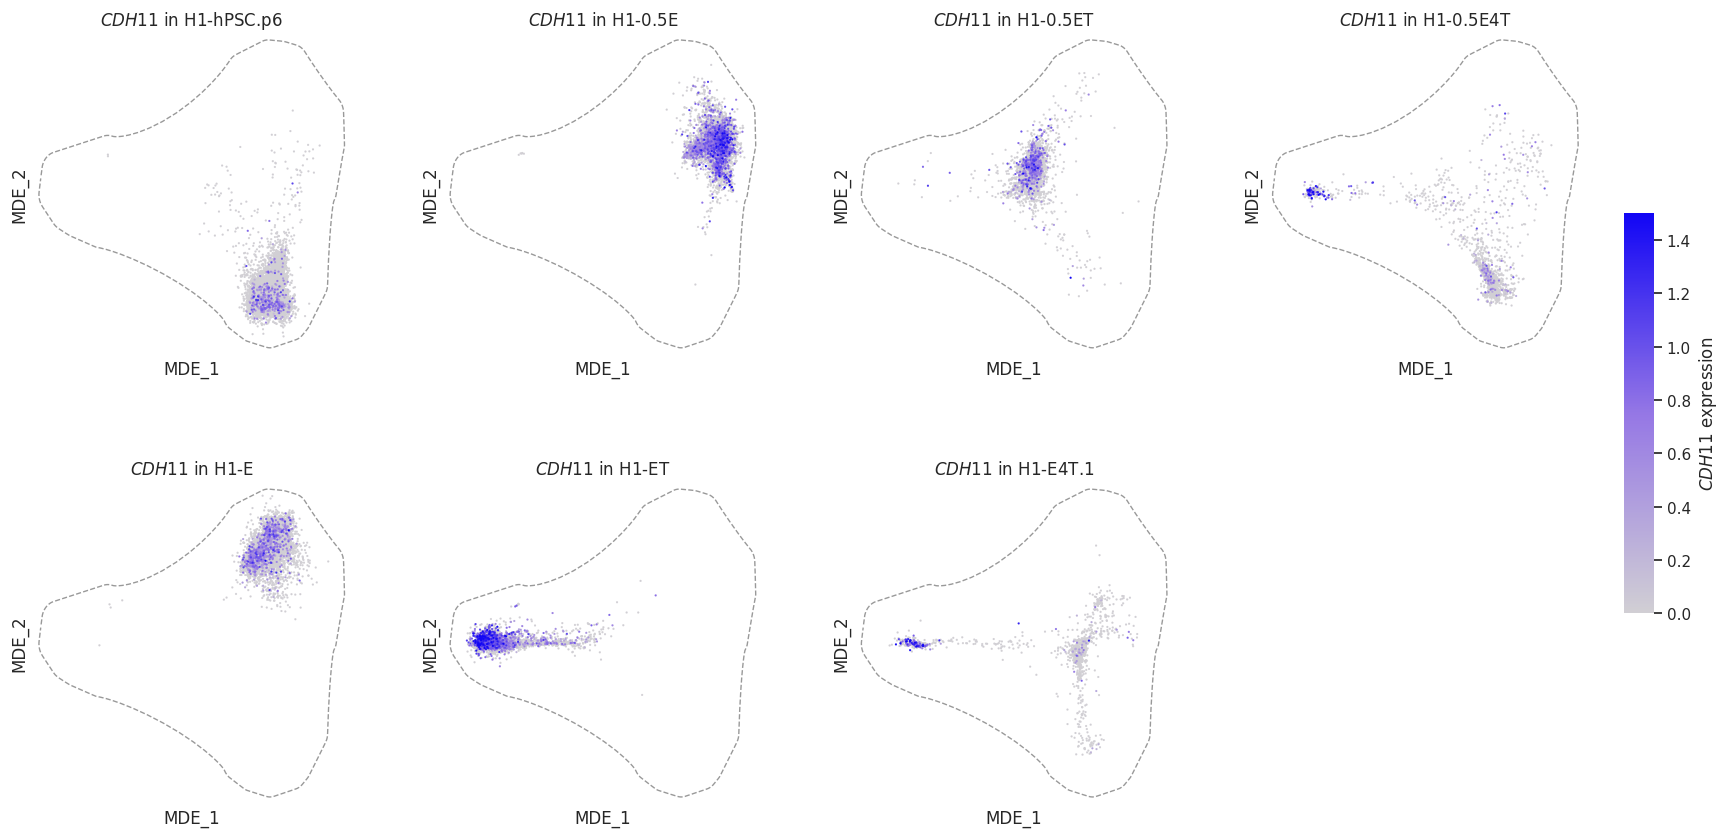

Saved: figures/Figure1.FOSL1.MDEmap.pdf


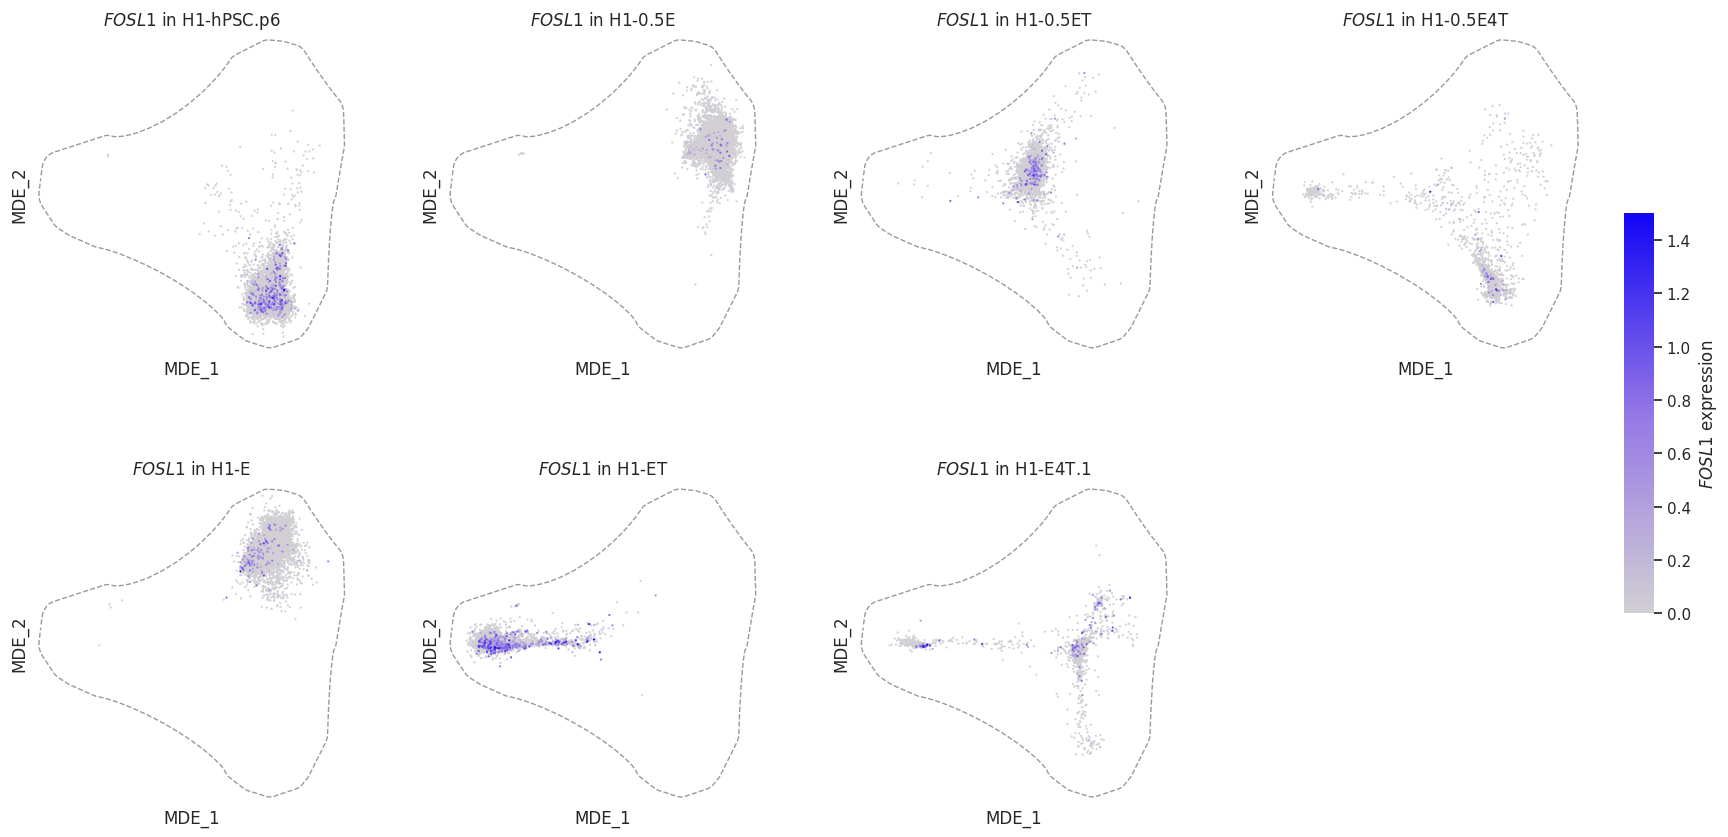

Saved: figures/Figure1.NFATC4.MDEmap.pdf


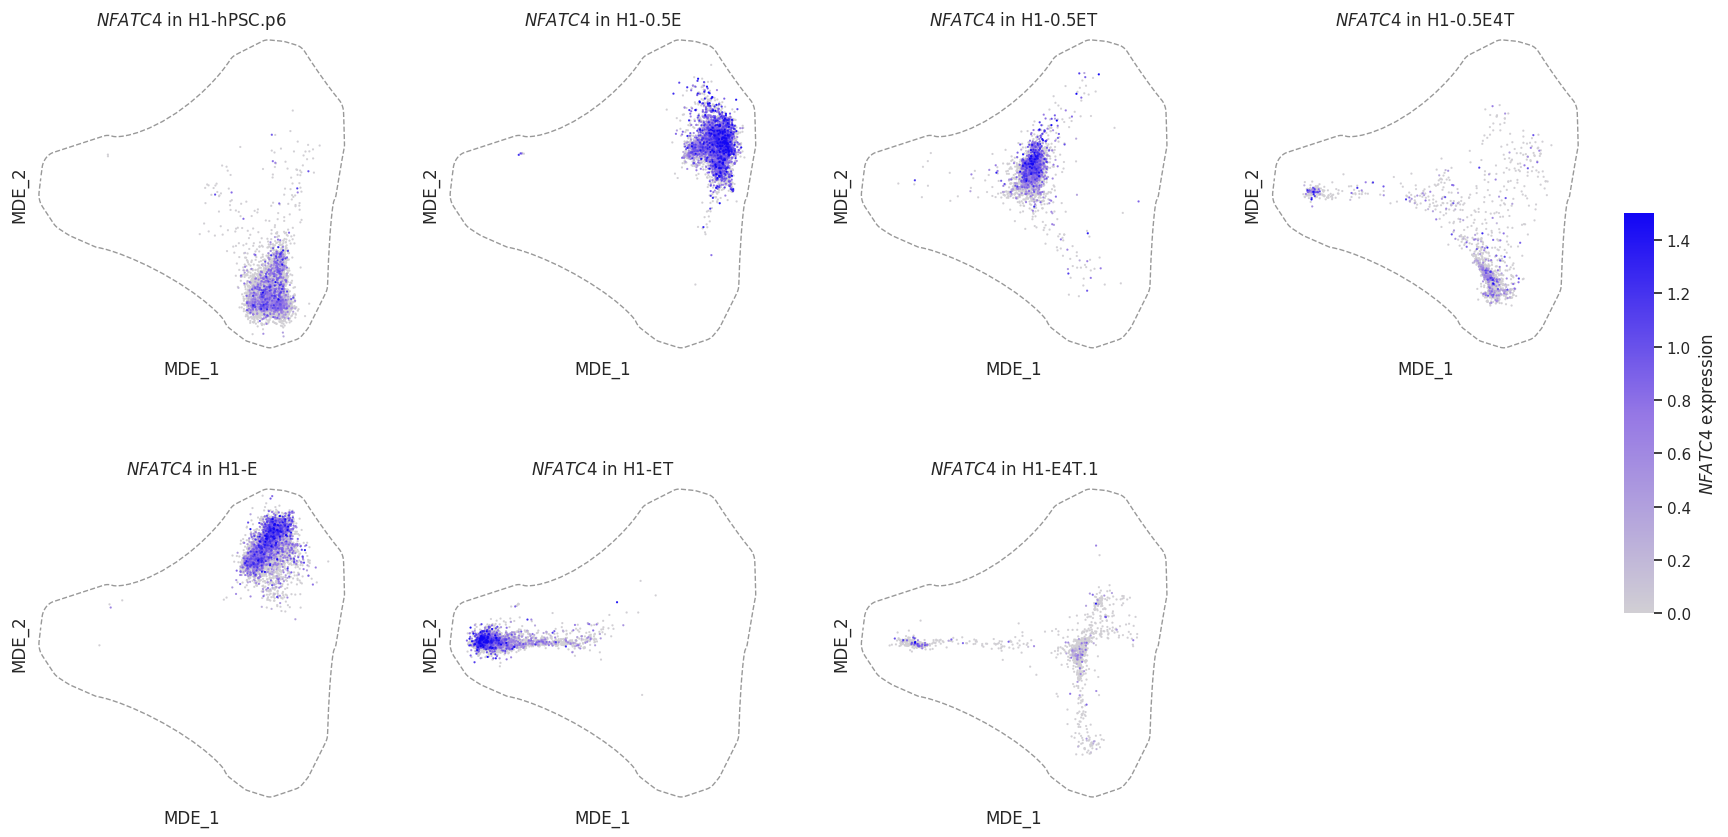

In [24]:
for g in ["NANOG","SOX21","OTX2","ZIC1","NES","SOX1","MAP2","COL2A1","TFAP2C","CDH11","FOSL1","NFATC4" ]:
    assert g in adata1.var_names.tolist()
    plot_gene_mde(g, adata1, fig1_samples, hull_coords,
              f'figures/Figure1.{g}.MDEmap.pdf')
    

## Figure 2 — MDE feature plot

Saved: figures/Figure2.NANOG.MDEmap.pdf


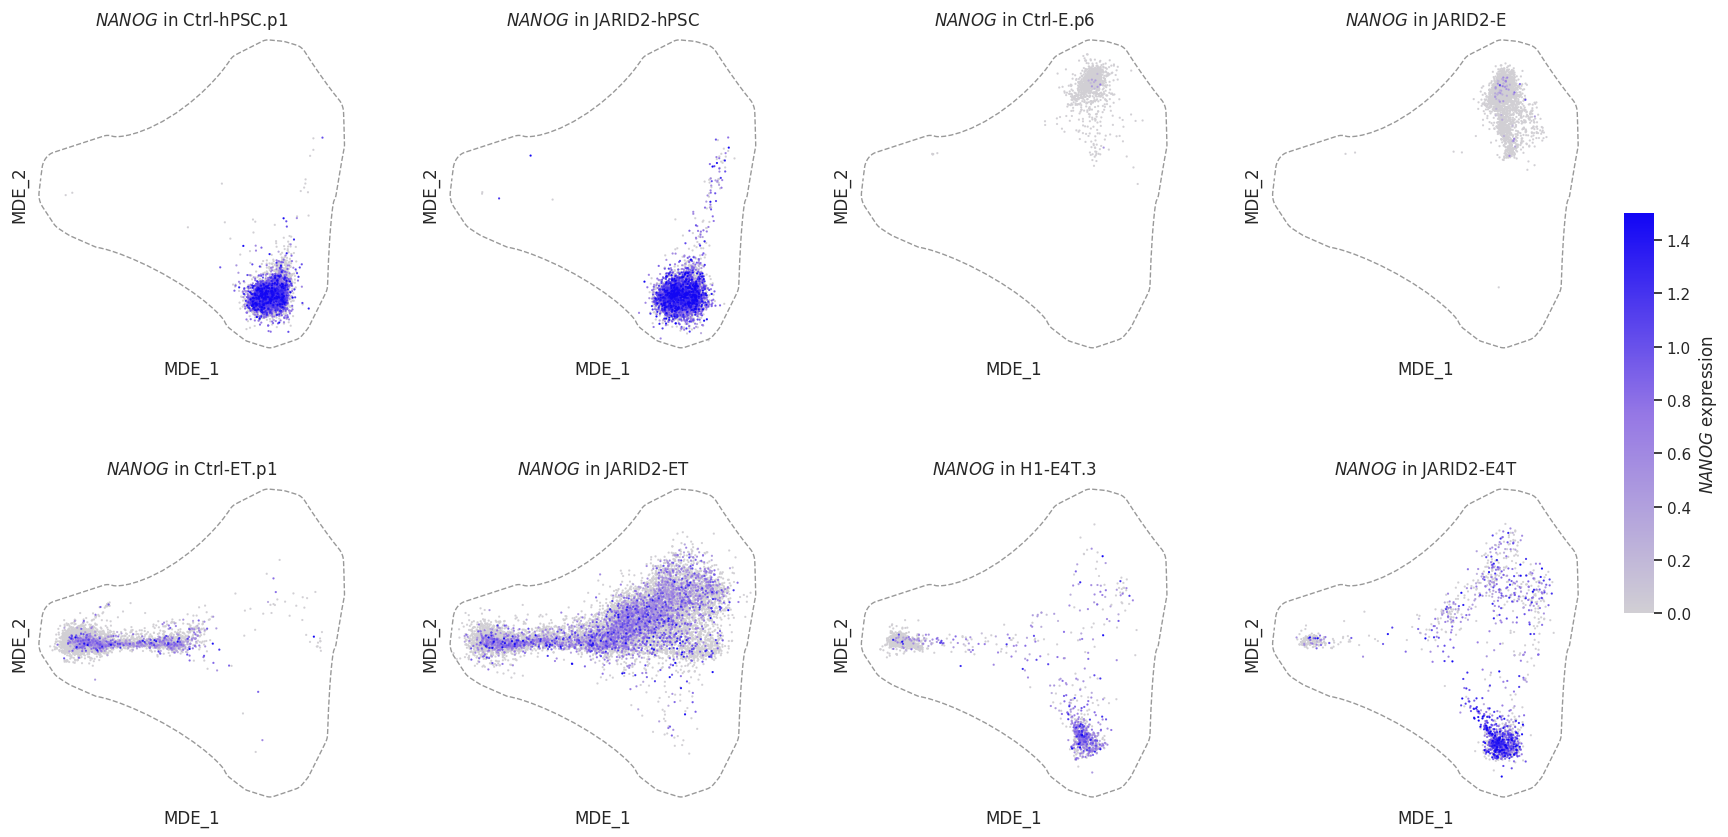

Saved: figures/Figure2.SOX21.MDEmap.pdf


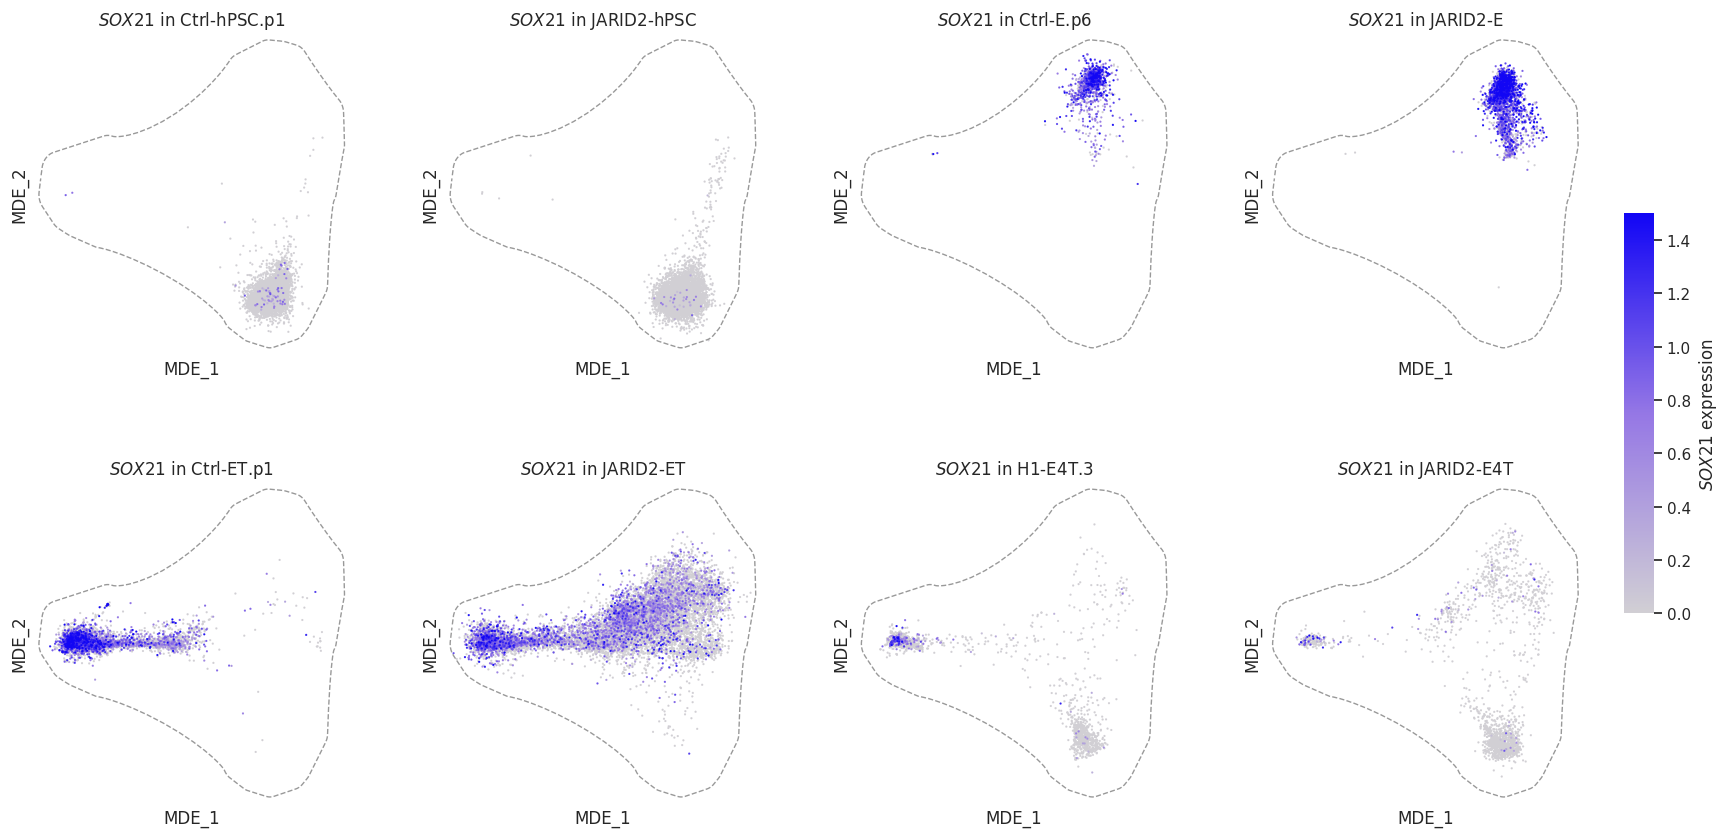

Saved: figures/Figure2.OTX2.MDEmap.pdf


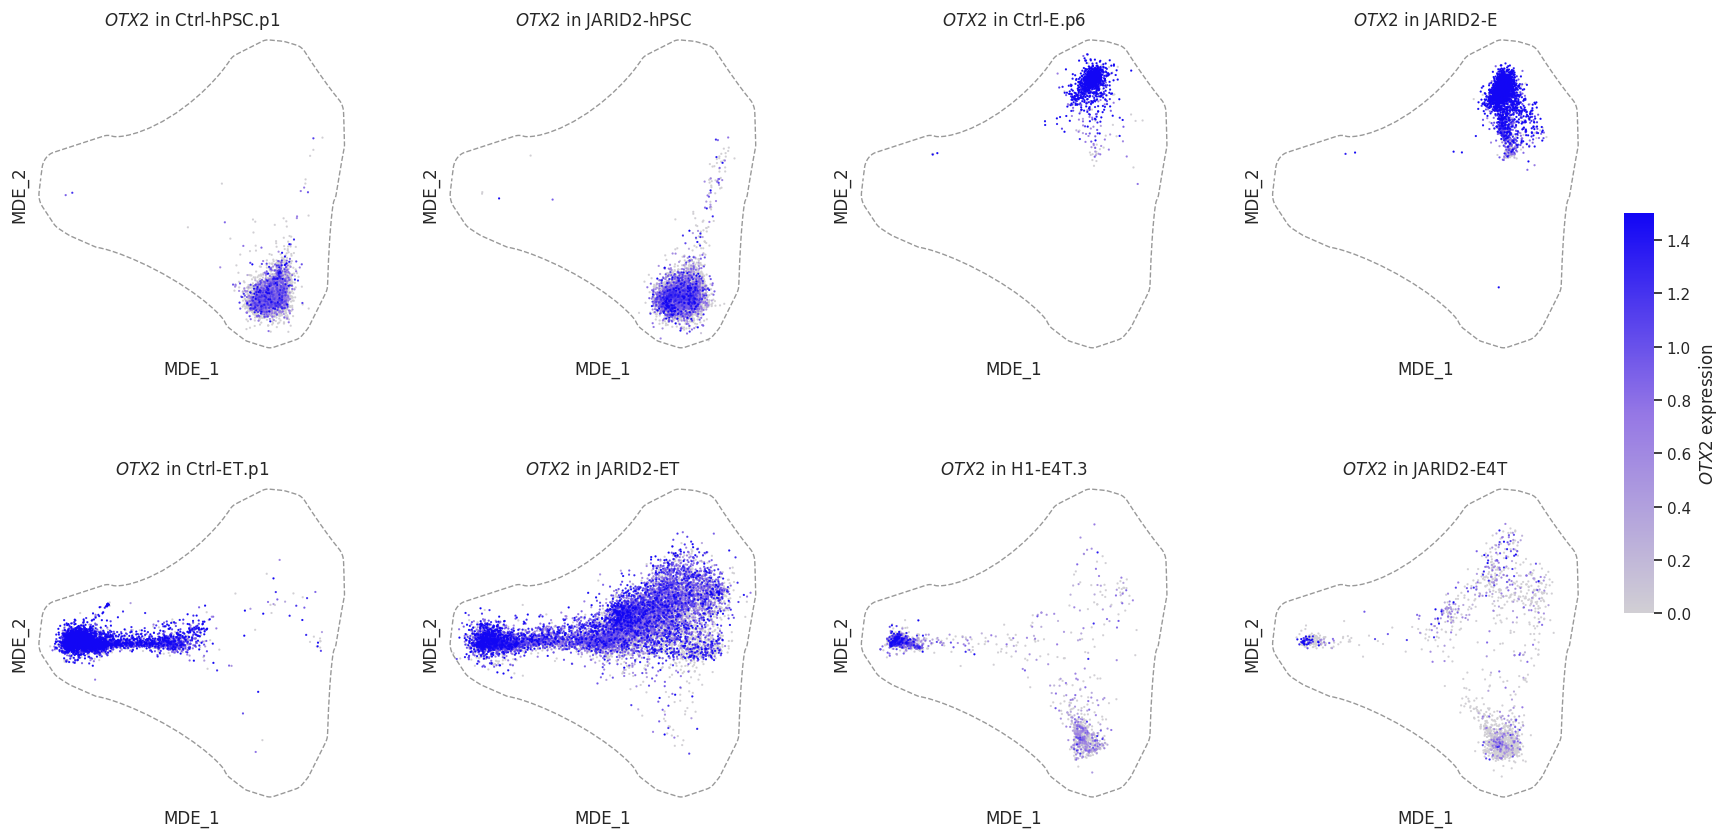

Saved: figures/Figure2.ZIC1.MDEmap.pdf


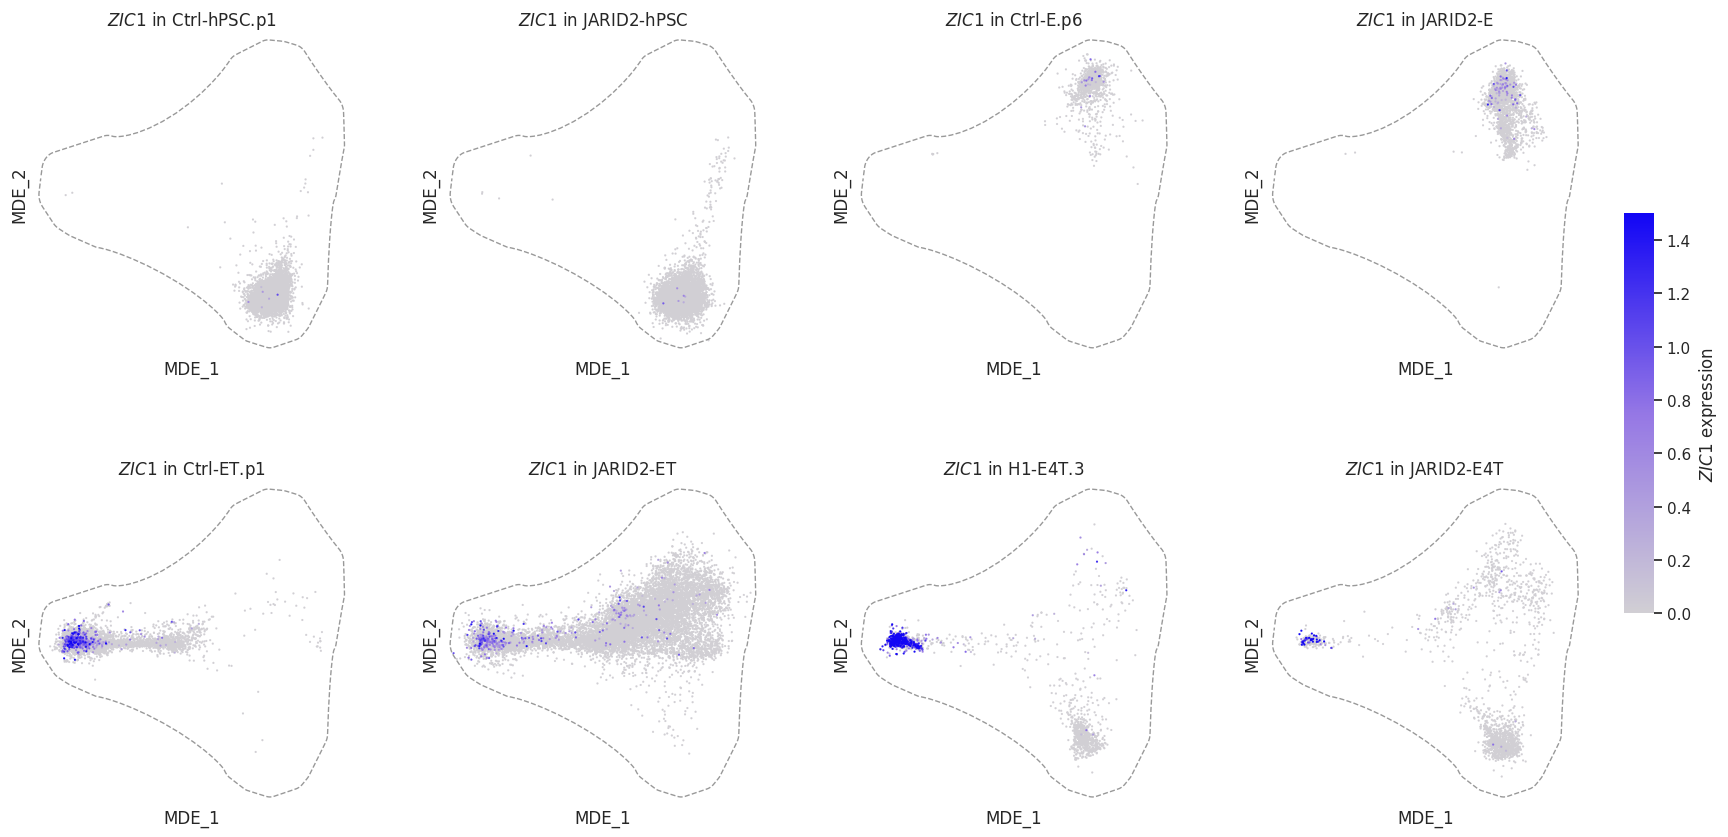

Saved: figures/Figure2.NES.MDEmap.pdf


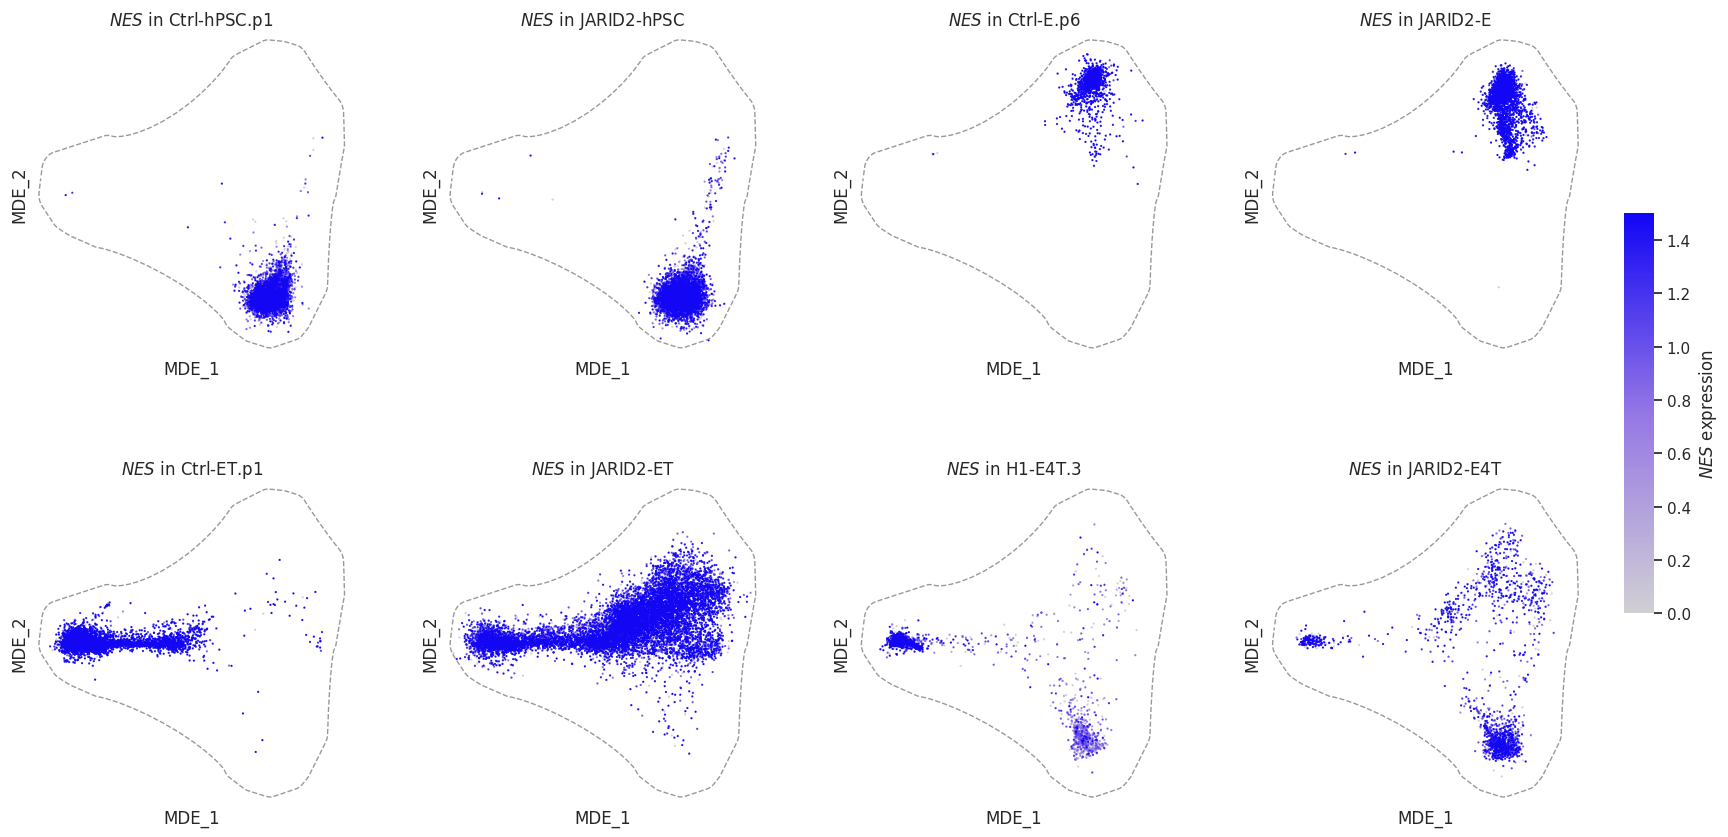

Saved: figures/Figure2.SOX1.MDEmap.pdf


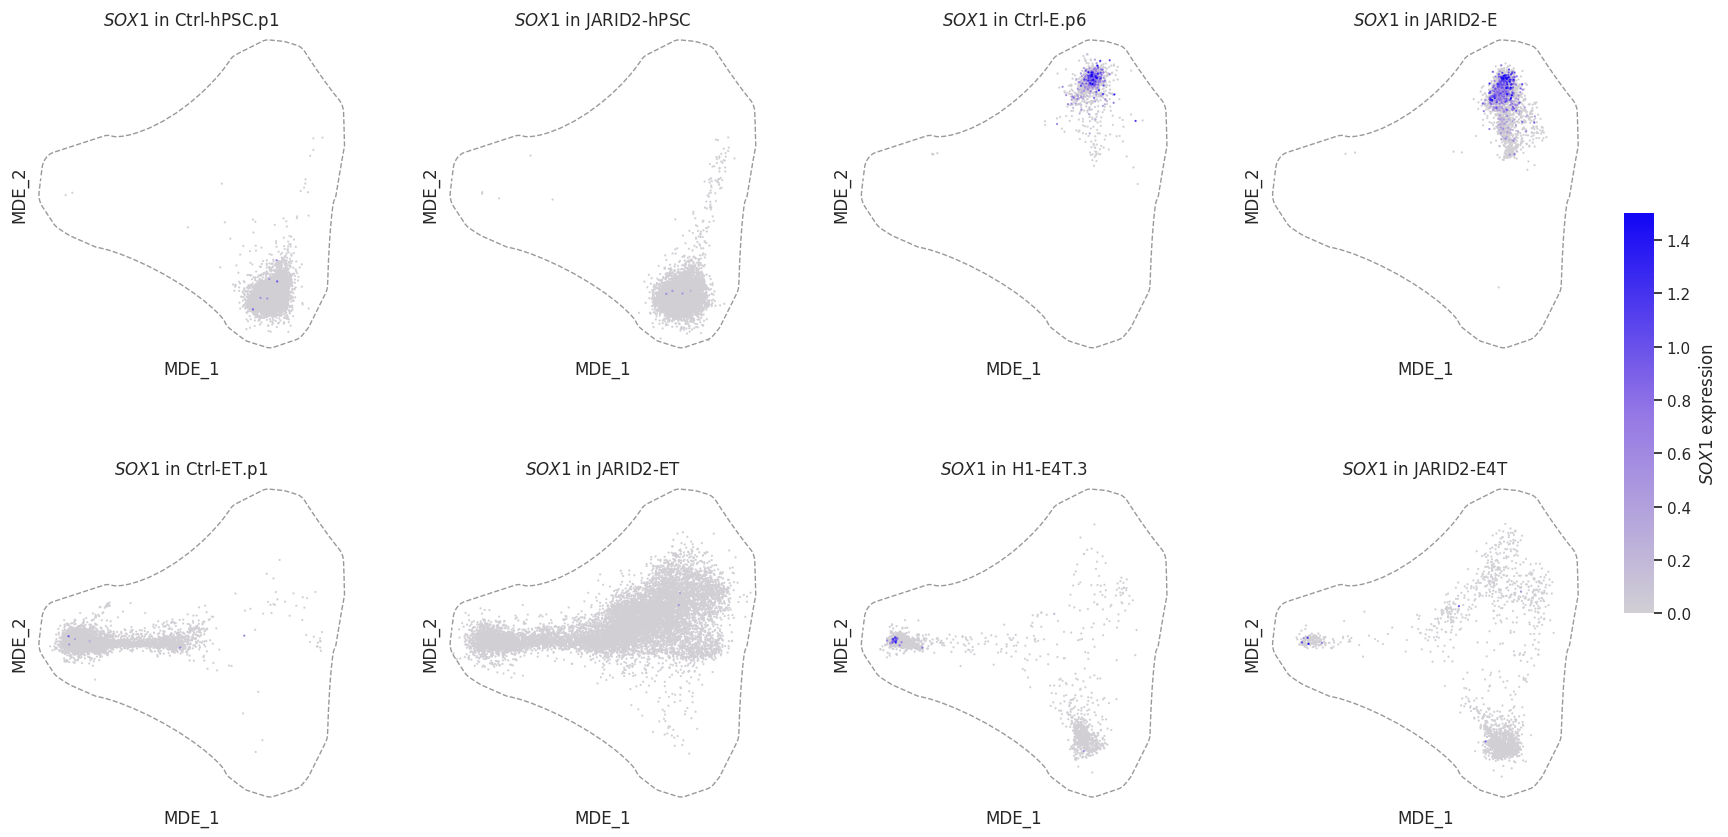

Saved: figures/Figure2.MAP2.MDEmap.pdf


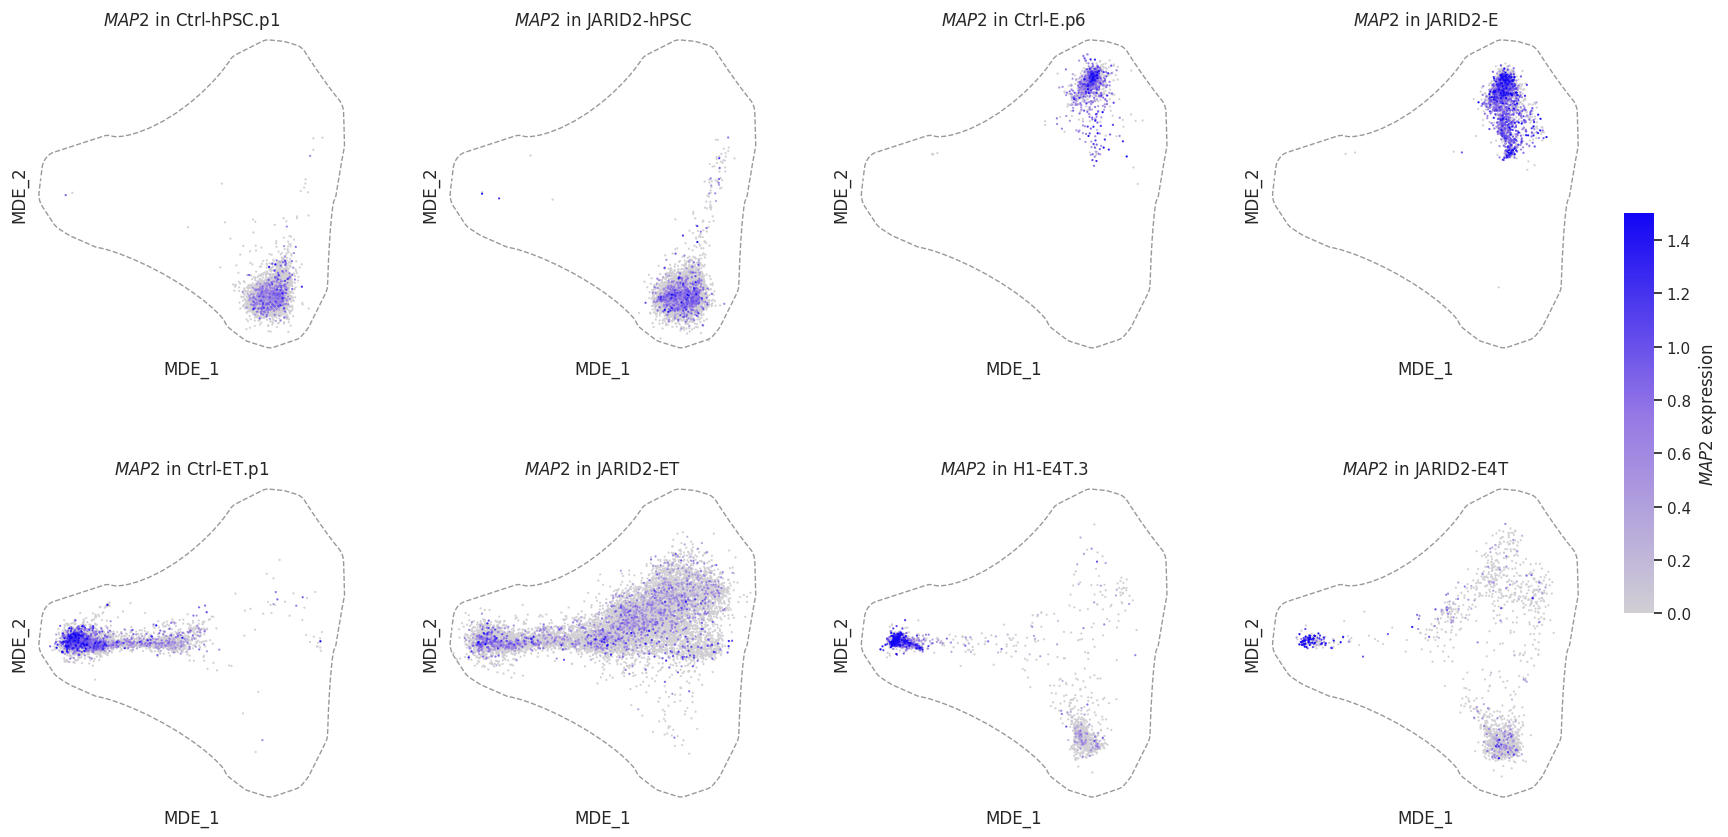

Saved: figures/Figure2.COL2A1.MDEmap.pdf


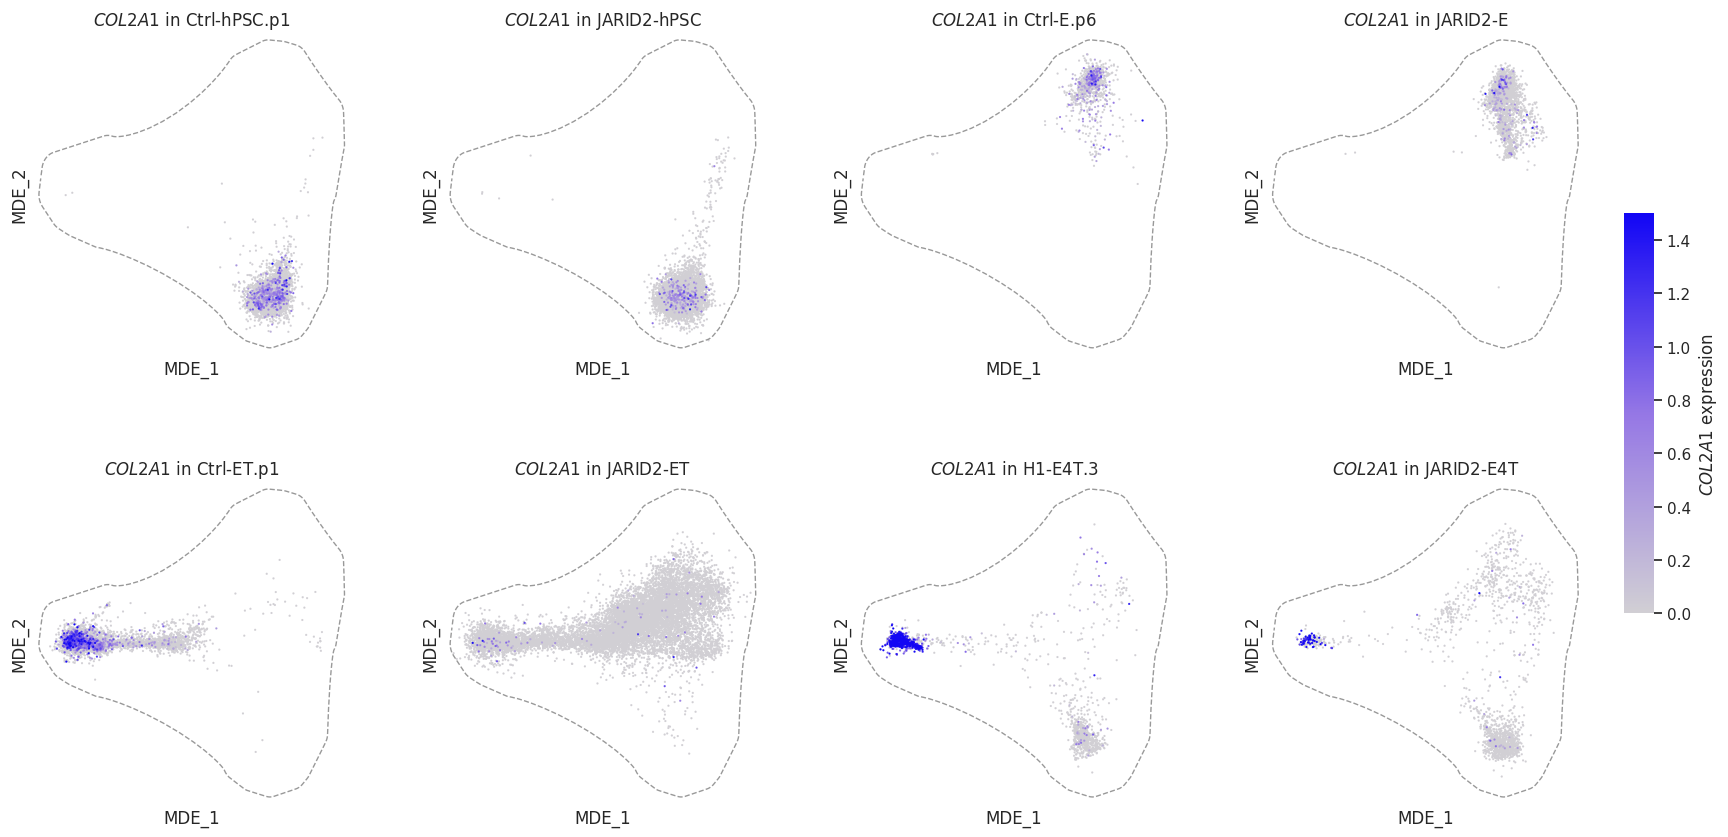

Saved: figures/Figure2.TFAP2C.MDEmap.pdf


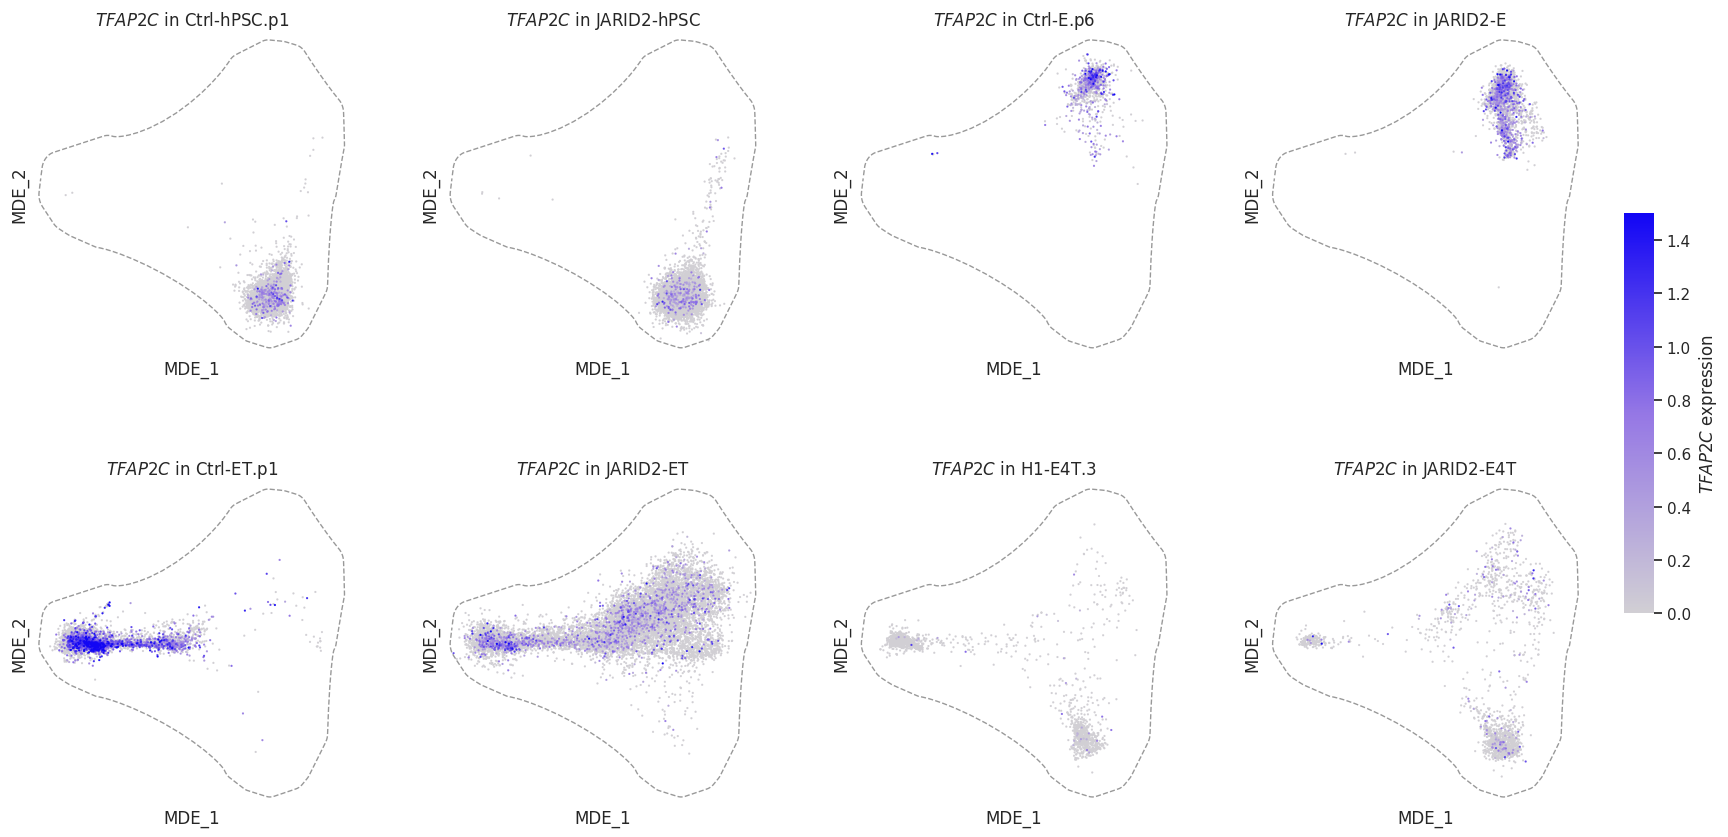

Saved: figures/Figure2.CDH11.MDEmap.pdf


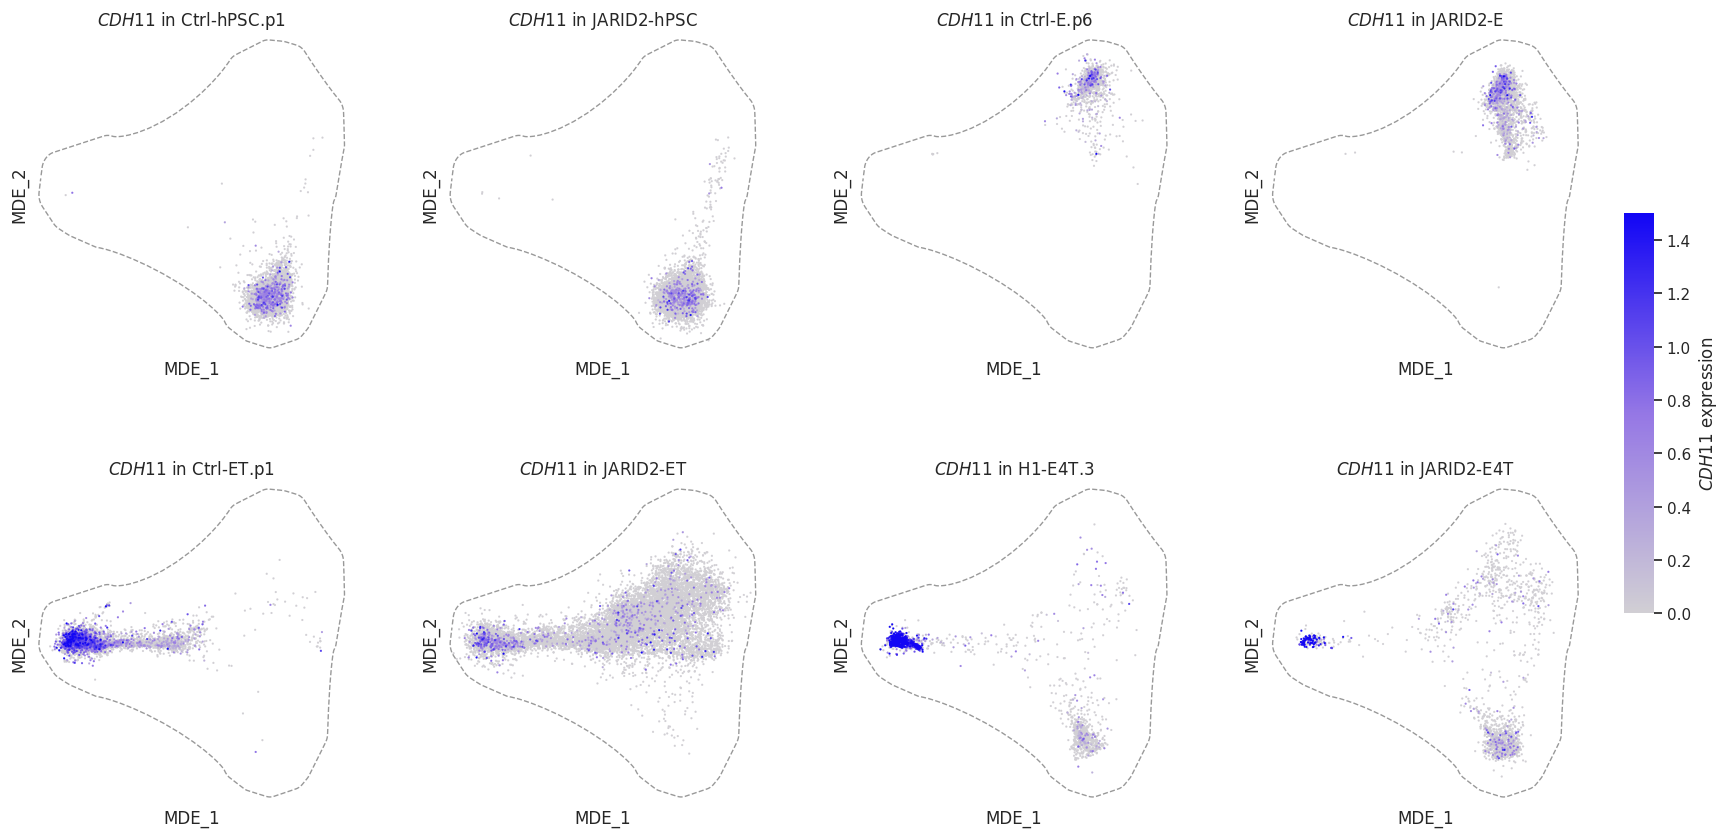

Saved: figures/Figure2.FOSL1.MDEmap.pdf


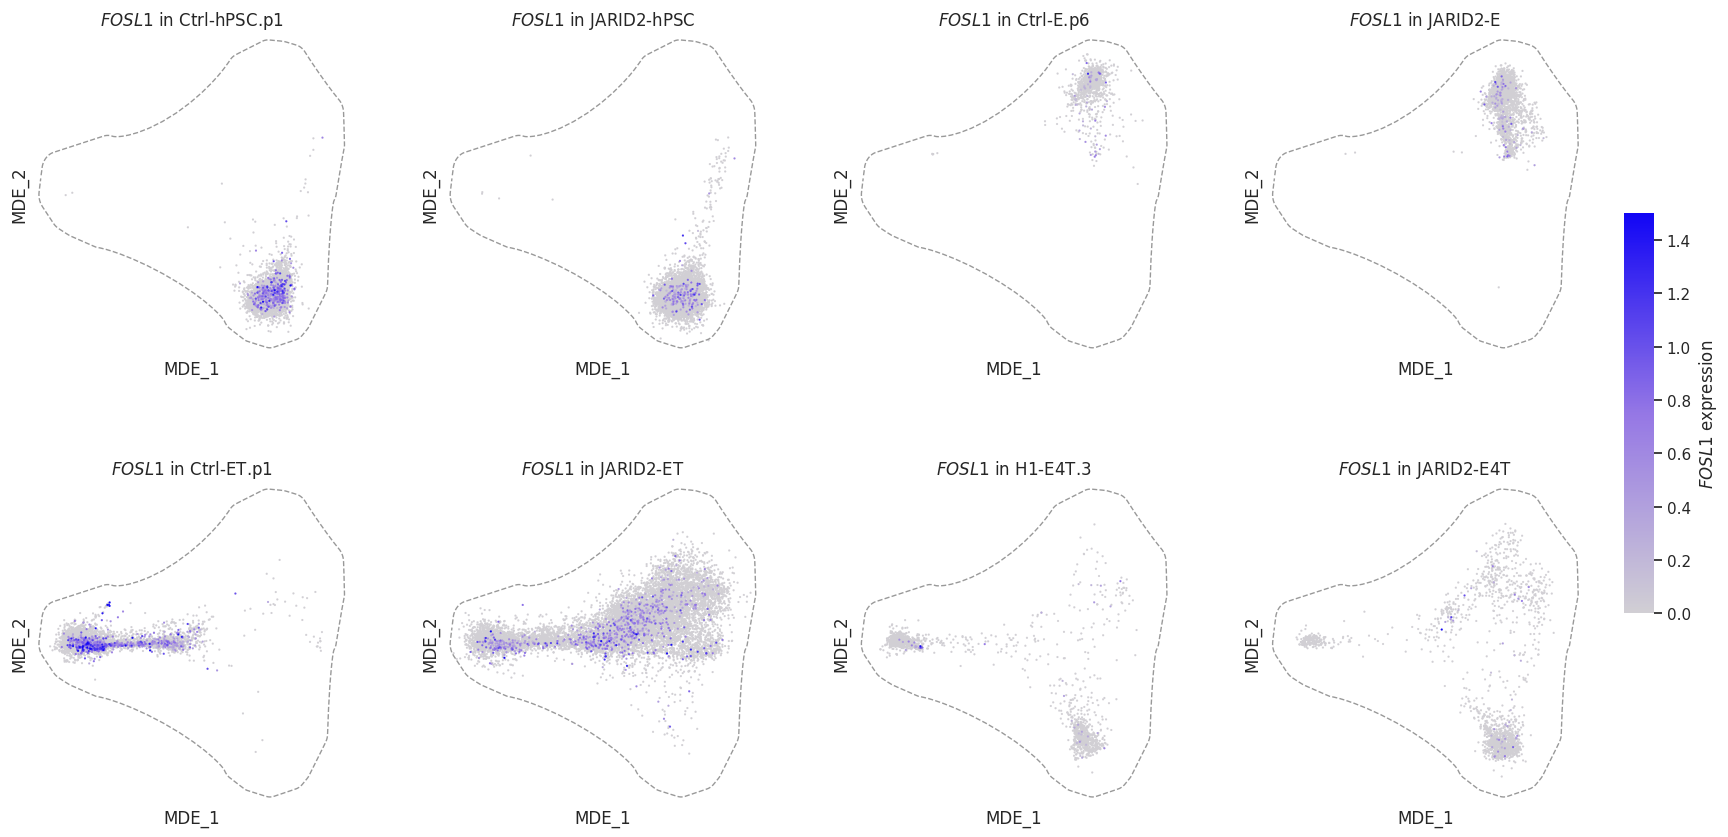

Saved: figures/Figure2.NFATC4.MDEmap.pdf


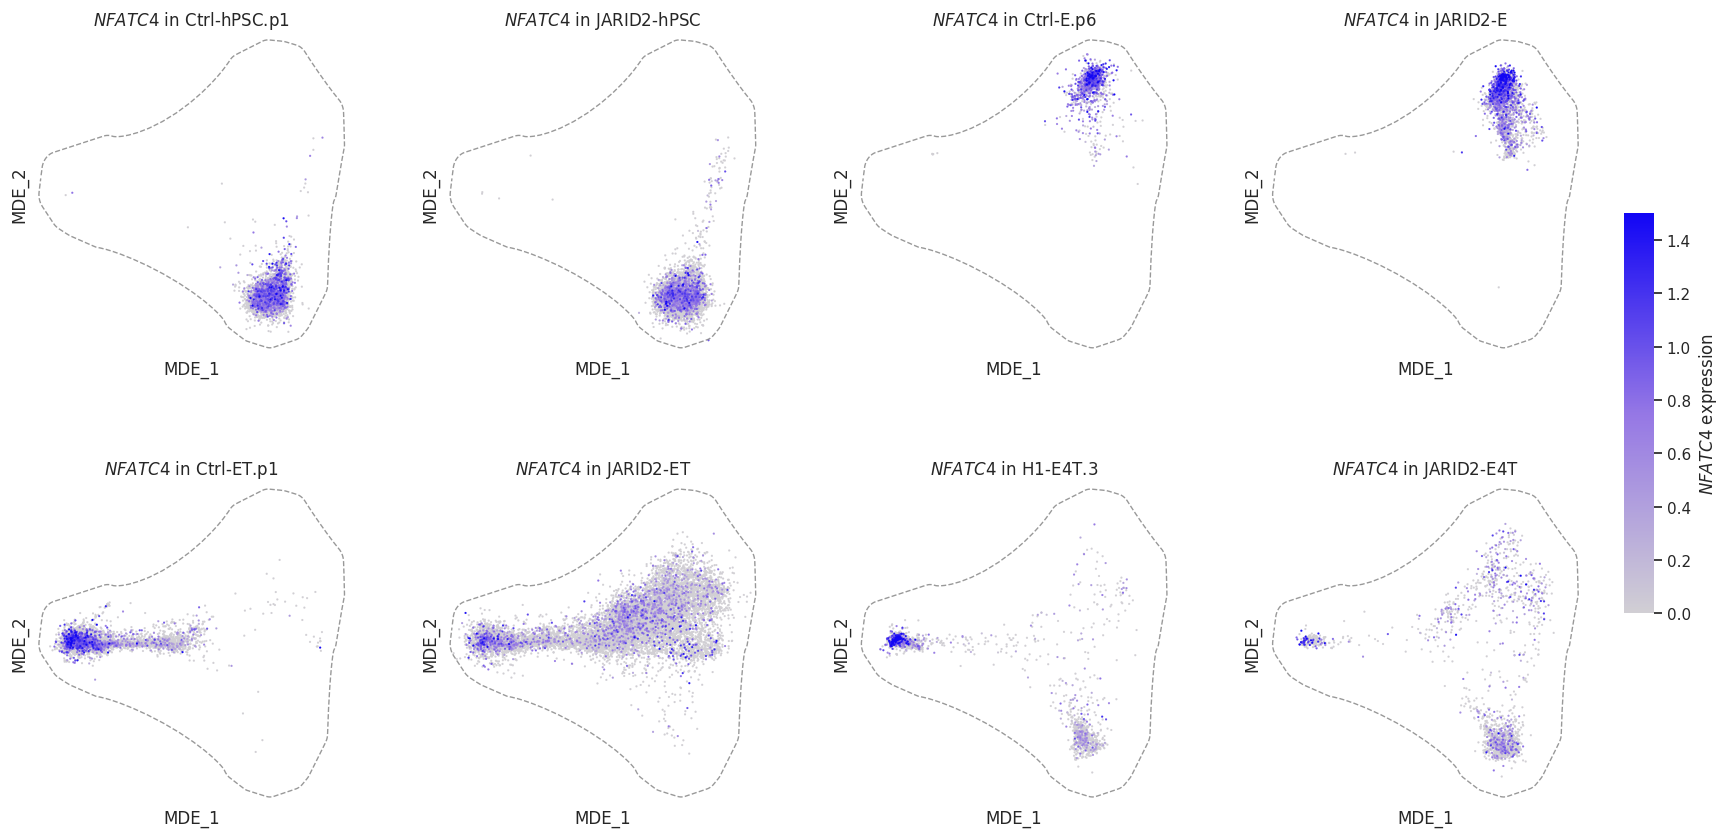

In [25]:
for g in ["NANOG","SOX21","OTX2","ZIC1","NES","SOX1","MAP2","COL2A1","TFAP2C","CDH11","FOSL1","NFATC4" ]:
    assert g in adata1.var_names.tolist()
    plot_gene_mde(g, adata2, fig2_samples, hull_coords,
              f'figures/Figure2.{g}.MDEmap.pdf')
    

In [26]:
!zip -r figures-v260224.zip figures

  adding: figures/ (stored 0%)
  adding: figures/Figure2.FOSL1.violin.pdf (deflated 28%)
  adding: figures/Figure1.MAP2.violin.pdf (deflated 28%)
  adding: figures/Figure1.OTX2.MDEmap.pdf (deflated 2%)
  adding: figures/Figure2.NFATC4.MDEmap.pdf (deflated 2%)
  adding: figures/Figure1.FOSL1.MDEmap.pdf (deflated 2%)
  adding: figures/Figure1.CDH11.violin.pdf (deflated 28%)
  adding: figures/Figure1.TFAP2C.violin.pdf (deflated 28%)
  adding: figures/Figure2.NES.MDEmap.pdf (deflated 2%)
  adding: figures/Figure2.ZIC1.violin.pdf (deflated 29%)
  adding: figures/.ipynb_checkpoints/ (stored 0%)
  adding: figures/.ipynb_checkpoints/Figure2.Samples.MDEmap-checkpoint.pdf (deflated 2%)
  adding: figures/Figure2.TFAP2C.violin.pdf (deflated 28%)
  adding: figures/Figure1.TFAP2C.MDEmap.pdf (deflated 2%)
  adding: figures/Figure2.NFATC4.violin.pdf (deflated 28%)
  adding: figures/Figure1.CDH11.MDEmap.pdf (deflated 2%)
  adding: figures/Figure2.MAP2.MDEmap.pdf (deflated 2%)
  adding: figures/Figure2.